# 顧客セグメンテーション

## 概要

### 概略
1. [データ準備](#データ準備)
1. [データ探索](#データ探索)
1. [顧客クラス分類](#顧客クラス分類)

In [ ]:
!pip3 install nltk
!pip3 install sklearn
!pip3 install wordcloud
!pip3 install plotly

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

## データ準備

データを読み込み、データ型と欠損値を確認

In [2]:
#__________________
# read the datafile
df_initial = pd.read_csv('./input/data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
#______
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


データのサンプル（先頭５件）を確認

In [3]:
#__________________
# show first lines
display(df_initial[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


欠損値（必須項目）データを削除

In [4]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


重複データの確認と削除

In [5]:
print('Entries Duplicated: {}'.format(df_initial.duplicated().sum()))

Entries Duplicated: 5225


In [7]:
df_initial.drop_duplicates(inplace = True)
print('Entries Duplicated: {}'.format(df_initial.duplicated().sum()))

Entries Duplicated: 0


## データ探索

### 地域

In [8]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No. of countries in the dataframe: {}'.format(len(countries)))

No. of countries in the dataframe: 37


In [9]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

In [19]:
df_cleaned = df_initial[:100]
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
95,536378,22352,LUNCH BOX WITH CUTLERY RETROSPOT,6,2010-12-01 09:37:00,2.55,14688,United Kingdom,0
96,536378,21212,PACK OF 72 RETROSPOT CAKE CASES,120,2010-12-01 09:37:00,0.42,14688,United Kingdom,0
97,536378,21975,PACK OF 60 DINOSAUR CAKE CASES,24,2010-12-01 09:37:00,0.55,14688,United Kingdom,0
98,536378,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,2010-12-01 09:37:00,0.55,14688,United Kingdom,0


In [21]:
for index, col in  df_initial.iterrows():
    print("index:", index)

index: 0
index: 1
index: 2
index: 3
index: 4
index: 5
index: 6
index: 7
index: 8
index: 9
index: 10
index: 11
index: 12
index: 13
index: 14
index: 15
index: 16
index: 17
index: 18
index: 19
index: 20
index: 21
index: 22
index: 23
index: 24
index: 25
index: 26
index: 27
index: 28
index: 29
index: 30
index: 31
index: 32
index: 33
index: 34
index: 35
index: 36
index: 37
index: 38
index: 39
index: 40
index: 41
index: 42
index: 43
index: 44
index: 45
index: 46
index: 47
index: 48
index: 49
index: 50
index: 51
index: 52
index: 53
index: 54
index: 55
index: 56
index: 57
index: 58
index: 59
index: 60
index: 61
index: 62
index: 63
index: 64
index: 65
index: 66
index: 67
index: 68
index: 69
index: 70
index: 71
index: 72
index: 73
index: 74
index: 75
index: 76
index: 77
index: 78
index: 79
index: 80
index: 81
index: 82
index: 83
index: 84
index: 85
index: 86
index: 87
index: 88
index: 89
index: 90
index: 91
index: 92
index: 93
index: 94
index: 95
index: 96
index: 97
index: 98
index: 99
index: 100

index: 1001
index: 1002
index: 1003
index: 1004
index: 1005
index: 1006
index: 1007
index: 1008
index: 1009
index: 1010
index: 1011
index: 1012
index: 1013
index: 1014
index: 1015
index: 1016
index: 1017
index: 1018
index: 1019
index: 1020
index: 1021
index: 1022
index: 1023
index: 1024
index: 1025
index: 1026
index: 1027
index: 1028
index: 1029
index: 1030
index: 1031
index: 1032
index: 1033
index: 1034
index: 1035
index: 1036
index: 1037
index: 1038
index: 1039
index: 1040
index: 1041
index: 1042
index: 1043
index: 1044
index: 1045
index: 1046
index: 1047
index: 1048
index: 1049
index: 1050
index: 1051
index: 1052
index: 1053
index: 1054
index: 1055
index: 1056
index: 1057
index: 1058
index: 1059
index: 1060
index: 1062
index: 1063
index: 1064
index: 1065
index: 1066
index: 1068
index: 1069
index: 1070
index: 1071
index: 1072
index: 1073
index: 1074
index: 1075
index: 1076
index: 1077
index: 1078
index: 1079
index: 1080
index: 1081
index: 1082
index: 1083
index: 1084
index: 1085
inde

index: 3121
index: 3122
index: 3123
index: 3124
index: 3125
index: 3126
index: 3127
index: 3128
index: 3129
index: 3130
index: 3131
index: 3132
index: 3133
index: 3134
index: 3135
index: 3136
index: 3137
index: 3138
index: 3139
index: 3140
index: 3141
index: 3142
index: 3143
index: 3144
index: 3145
index: 3146
index: 3147
index: 3148
index: 3149
index: 3150
index: 3151
index: 3152
index: 3153
index: 3154
index: 3155
index: 3156
index: 3157
index: 3158
index: 3159
index: 3160
index: 3161
index: 3162
index: 3163
index: 3164
index: 3165
index: 3166
index: 3167
index: 3168
index: 3169
index: 3170
index: 3171
index: 3172
index: 3173
index: 3174
index: 3175
index: 3176
index: 3177
index: 3178
index: 3179
index: 3180
index: 3181
index: 3182
index: 3183
index: 3184
index: 3185
index: 3186
index: 3187
index: 3188
index: 3189
index: 3190
index: 3191
index: 3192
index: 3193
index: 3194
index: 3195
index: 3196
index: 3197
index: 3198
index: 3199
index: 3200
index: 3201
index: 3202
index: 3203
inde

index: 4123
index: 4124
index: 4125
index: 4126
index: 4127
index: 4128
index: 4129
index: 4130
index: 4131
index: 4132
index: 4134
index: 4135
index: 4136
index: 4137
index: 4138
index: 4139
index: 4140
index: 4141
index: 4143
index: 4144
index: 4146
index: 4148
index: 4149
index: 4150
index: 4151
index: 4152
index: 4153
index: 4154
index: 4155
index: 4157
index: 4159
index: 4160
index: 4161
index: 4162
index: 4163
index: 4164
index: 4165
index: 4166
index: 4167
index: 4168
index: 4169
index: 4170
index: 4171
index: 4172
index: 4173
index: 4174
index: 4175
index: 4176
index: 4177
index: 4178
index: 4179
index: 4180
index: 4181
index: 4182
index: 4183
index: 4184
index: 4185
index: 4186
index: 4187
index: 4188
index: 4189
index: 4190
index: 4191
index: 4192
index: 4193
index: 4194
index: 4195
index: 4196
index: 4197
index: 4198
index: 4199
index: 4200
index: 4201
index: 4202
index: 4203
index: 4204
index: 4205
index: 4206
index: 4207
index: 4208
index: 4209
index: 4210
index: 4211
inde

index: 5188
index: 5189
index: 5190
index: 5191
index: 5192
index: 5193
index: 5194
index: 5195
index: 5196
index: 5197
index: 5198
index: 5199
index: 5200
index: 5201
index: 5203
index: 5205
index: 5206
index: 5207
index: 5208
index: 5209
index: 5211
index: 5212
index: 5214
index: 5215
index: 5216
index: 5217
index: 5218
index: 5219
index: 5220
index: 5221
index: 5222
index: 5223
index: 5224
index: 5225
index: 5226
index: 5227
index: 5228
index: 5229
index: 5230
index: 5231
index: 5232
index: 5233
index: 5234
index: 5235
index: 5236
index: 5237
index: 5238
index: 5239
index: 5240
index: 5241
index: 5242
index: 5243
index: 5244
index: 5245
index: 5246
index: 5247
index: 5248
index: 5249
index: 5250
index: 5251
index: 5252
index: 5253
index: 5254
index: 5255
index: 5256
index: 5257
index: 5258
index: 5259
index: 5260
index: 5261
index: 5262
index: 5263
index: 5264
index: 5265
index: 5266
index: 5267
index: 5268
index: 5269
index: 5270
index: 5271
index: 5272
index: 5273
index: 5274
inde

index: 7239
index: 7240
index: 7241
index: 7242
index: 7243
index: 7244
index: 7245
index: 7246
index: 7247
index: 7248
index: 7249
index: 7250
index: 7251
index: 7252
index: 7253
index: 7254
index: 7255
index: 7256
index: 7257
index: 7258
index: 7259
index: 7260
index: 7261
index: 7262
index: 7278
index: 7279
index: 7280
index: 7281
index: 7282
index: 7283
index: 7284
index: 7285
index: 7286
index: 7287
index: 7288
index: 7289
index: 7290
index: 7294
index: 7295
index: 7296
index: 7297
index: 7298
index: 7299
index: 7300
index: 7301
index: 7302
index: 7303
index: 7304
index: 7305
index: 7306
index: 7307
index: 7308
index: 7309
index: 7310
index: 7311
index: 7312
index: 7314
index: 7315
index: 7316
index: 7317
index: 7318
index: 7319
index: 7320
index: 7321
index: 7322
index: 7323
index: 7324
index: 7325
index: 7326
index: 7327
index: 7328
index: 7329
index: 7330
index: 7331
index: 7332
index: 7333
index: 7334
index: 7335
index: 7336
index: 7337
index: 7338
index: 7339
index: 7340
inde

index: 8249
index: 8250
index: 8252
index: 8253
index: 8254
index: 8255
index: 8256
index: 8257
index: 8258
index: 8259
index: 8260
index: 8261
index: 8262
index: 8263
index: 8264
index: 8265
index: 8266
index: 8267
index: 8268
index: 8269
index: 8270
index: 8271
index: 8272
index: 8273
index: 8274
index: 8275
index: 8276
index: 8277
index: 8278
index: 8279
index: 8280
index: 8281
index: 8282
index: 8283
index: 8284
index: 8285
index: 8286
index: 8287
index: 8288
index: 8289
index: 8290
index: 8291
index: 8293
index: 8294
index: 8295
index: 8296
index: 8297
index: 8298
index: 8299
index: 8300
index: 8301
index: 8302
index: 8303
index: 8304
index: 8305
index: 8306
index: 8307
index: 8308
index: 8309
index: 8311
index: 8315
index: 8316
index: 8317
index: 8318
index: 8319
index: 8320
index: 8321
index: 8322
index: 8323
index: 8324
index: 8325
index: 8326
index: 8327
index: 8328
index: 8329
index: 8330
index: 8331
index: 8332
index: 8333
index: 8334
index: 8335
index: 8336
index: 8337
inde

index: 9261
index: 9262
index: 9263
index: 9264
index: 9265
index: 9266
index: 9267
index: 9269
index: 9270
index: 9271
index: 9272
index: 9273
index: 9274
index: 9275
index: 9276
index: 9277
index: 9278
index: 9279
index: 9280
index: 9281
index: 9282
index: 9283
index: 9284
index: 9285
index: 9287
index: 9288
index: 9289
index: 9290
index: 9291
index: 9292
index: 9293
index: 9294
index: 9295
index: 9296
index: 9297
index: 9298
index: 9299
index: 9300
index: 9301
index: 9302
index: 9303
index: 9304
index: 9305
index: 9306
index: 9307
index: 9308
index: 9309
index: 9310
index: 9311
index: 9312
index: 9313
index: 9314
index: 9315
index: 9316
index: 9317
index: 9318
index: 9319
index: 9320
index: 9321
index: 9322
index: 9324
index: 9325
index: 9326
index: 9327
index: 9329
index: 9330
index: 9332
index: 9333
index: 9334
index: 9335
index: 9336
index: 9337
index: 9338
index: 9339
index: 9340
index: 9342
index: 9343
index: 9344
index: 9345
index: 9346
index: 9347
index: 9348
index: 9349
inde

index: 10836
index: 10837
index: 10838
index: 10839
index: 10840
index: 10841
index: 10842
index: 10843
index: 10844
index: 11413
index: 11414
index: 11415
index: 11416
index: 11417
index: 11418
index: 11419
index: 11420
index: 11421
index: 11422
index: 11423
index: 11424
index: 11425
index: 11426
index: 11427
index: 11428
index: 11429
index: 11430
index: 11431
index: 11432
index: 11433
index: 11434
index: 11435
index: 11436
index: 11437
index: 11438
index: 11439
index: 11440
index: 11441
index: 11442
index: 11443
index: 11444
index: 11445
index: 11446
index: 11447
index: 11448
index: 11449
index: 11450
index: 11451
index: 11452
index: 11453
index: 11454
index: 11455
index: 11456
index: 11457
index: 11458
index: 11459
index: 11460
index: 11461
index: 11462
index: 11463
index: 11464
index: 11465
index: 11466
index: 11467
index: 11468
index: 11469
index: 11470
index: 11471
index: 11472
index: 11473
index: 11474
index: 11475
index: 11476
index: 11477
index: 11478
index: 11479
index: 11480

index: 12444
index: 12445
index: 12446
index: 12447
index: 12448
index: 12449
index: 12450
index: 12451
index: 12452
index: 12453
index: 12454
index: 12455
index: 12456
index: 12457
index: 12458
index: 12459
index: 12460
index: 12461
index: 12462
index: 12463
index: 12464
index: 12465
index: 12466
index: 12467
index: 12468
index: 12469
index: 12470
index: 12471
index: 12472
index: 12473
index: 12474
index: 12475
index: 12476
index: 12477
index: 12478
index: 12479
index: 12480
index: 12481
index: 12482
index: 12483
index: 12484
index: 12485
index: 12486
index: 12487
index: 12488
index: 12489
index: 12490
index: 12491
index: 12492
index: 12493
index: 12494
index: 12495
index: 12496
index: 12497
index: 12498
index: 12499
index: 12500
index: 12501
index: 12502
index: 12503
index: 12504
index: 12505
index: 12506
index: 12507
index: 12508
index: 12509
index: 12510
index: 12511
index: 12512
index: 12513
index: 12514
index: 12515
index: 12516
index: 12518
index: 12519
index: 12520
index: 12521

index: 14105
index: 14106
index: 14107
index: 14108
index: 14109
index: 14110
index: 14111
index: 14112
index: 14113
index: 14114
index: 14115
index: 14116
index: 14117
index: 14118
index: 14119
index: 14120
index: 14121
index: 14122
index: 14123
index: 14124
index: 14125
index: 14126
index: 14127
index: 14128
index: 14129
index: 14130
index: 14131
index: 14132
index: 14133
index: 14134
index: 14135
index: 14136
index: 14137
index: 14138
index: 14139
index: 14140
index: 14141
index: 14142
index: 14143
index: 14144
index: 14145
index: 14146
index: 14147
index: 14148
index: 14149
index: 14150
index: 14151
index: 14152
index: 14153
index: 14154
index: 14155
index: 14156
index: 14157
index: 14158
index: 14159
index: 14160
index: 14161
index: 14162
index: 14163
index: 14164
index: 14165
index: 14166
index: 14167
index: 14168
index: 14169
index: 14170
index: 14171
index: 14172
index: 14173
index: 14174
index: 14175
index: 14176
index: 14177
index: 14178
index: 14179
index: 14180
index: 14181

index: 16387
index: 16388
index: 16389
index: 16390
index: 16393
index: 16394
index: 16416
index: 16417
index: 16418
index: 16419
index: 16420
index: 16421
index: 16422
index: 16423
index: 16424
index: 16425
index: 16426
index: 16427
index: 16428
index: 16429
index: 16430
index: 16431
index: 16432
index: 16433
index: 16434
index: 16435
index: 16436
index: 16437
index: 16438
index: 16439
index: 16440
index: 16441
index: 16442
index: 16443
index: 16444
index: 16445
index: 16446
index: 16447
index: 16448
index: 16985
index: 16986
index: 16987
index: 16988
index: 16989
index: 16990
index: 16991
index: 16992
index: 16993
index: 16994
index: 16995
index: 16996
index: 16997
index: 16998
index: 16999
index: 17000
index: 17001
index: 17002
index: 17003
index: 17004
index: 17005
index: 17006
index: 17007
index: 17008
index: 17009
index: 17010
index: 17011
index: 17012
index: 17013
index: 17014
index: 17015
index: 17016
index: 17017
index: 17018
index: 17019
index: 17020
index: 17021
index: 17022

index: 17915
index: 17916
index: 17917
index: 17918
index: 17919
index: 17920
index: 17921
index: 17922
index: 17923
index: 17924
index: 17926
index: 17928
index: 17929
index: 17930
index: 17931
index: 17935
index: 17936
index: 17937
index: 17938
index: 17939
index: 17940
index: 17943
index: 17944
index: 17945
index: 17946
index: 17947
index: 17948
index: 17949
index: 17950
index: 17952
index: 17954
index: 17955
index: 17956
index: 17958
index: 17962
index: 17963
index: 17964
index: 17966
index: 17970
index: 17972
index: 17973
index: 17974
index: 17975
index: 17976
index: 17977
index: 17978
index: 17979
index: 17980
index: 17981
index: 17982
index: 17983
index: 17984
index: 17985
index: 17986
index: 17987
index: 17988
index: 17989
index: 17990
index: 17991
index: 17992
index: 17993
index: 17994
index: 17995
index: 17996
index: 17997
index: 17998
index: 17999
index: 18000
index: 18001
index: 18003
index: 18004
index: 18005
index: 18007
index: 18008
index: 18009
index: 18010
index: 18011

index: 19482
index: 19483
index: 19484
index: 19485
index: 19486
index: 19487
index: 19488
index: 19489
index: 19490
index: 19491
index: 19492
index: 19493
index: 19494
index: 19495
index: 19496
index: 19497
index: 19498
index: 19499
index: 19500
index: 19501
index: 19502
index: 19503
index: 19504
index: 19505
index: 19506
index: 19507
index: 19508
index: 19509
index: 19510
index: 19511
index: 19512
index: 19513
index: 19514
index: 19515
index: 19516
index: 19517
index: 19518
index: 19519
index: 19520
index: 19521
index: 19522
index: 19523
index: 19524
index: 19525
index: 19526
index: 19527
index: 19528
index: 19529
index: 19530
index: 19531
index: 19532
index: 19533
index: 19534
index: 19535
index: 19536
index: 19537
index: 19538
index: 19539
index: 19540
index: 19541
index: 19542
index: 19543
index: 19544
index: 19545
index: 19546
index: 19547
index: 19548
index: 19549
index: 19550
index: 19551
index: 19552
index: 19553
index: 19554
index: 19555
index: 19556
index: 19557
index: 19558

index: 20503
index: 20504
index: 20505
index: 20507
index: 20508
index: 20509
index: 20510
index: 20511
index: 20512
index: 20513
index: 20514
index: 20515
index: 20516
index: 20517
index: 20518
index: 20519
index: 20520
index: 20523
index: 20524
index: 20525
index: 20526
index: 20527
index: 20528
index: 20529
index: 20530
index: 20531
index: 20532
index: 20533
index: 20534
index: 20535
index: 20536
index: 20537
index: 20538
index: 20539
index: 20540
index: 20541
index: 20542
index: 20543
index: 20544
index: 20545
index: 20546
index: 20547
index: 20548
index: 20549
index: 20550
index: 20551
index: 20552
index: 20553
index: 20554
index: 20555
index: 20556
index: 20557
index: 20558
index: 20559
index: 20560
index: 20561
index: 20562
index: 20563
index: 20564
index: 20565
index: 20566
index: 20567
index: 20568
index: 20569
index: 20570
index: 20571
index: 20572
index: 20573
index: 20574
index: 20575
index: 20576
index: 20577
index: 20578
index: 20579
index: 20580
index: 20581
index: 20582

index: 23132
index: 23133
index: 23134
index: 23135
index: 23136
index: 23137
index: 23138
index: 23139
index: 23140
index: 23141
index: 23142
index: 23143
index: 23144
index: 23145
index: 23146
index: 23147
index: 23148
index: 23149
index: 23151
index: 23152
index: 23153
index: 23154
index: 23155
index: 23156
index: 23157
index: 23158
index: 23159
index: 23160
index: 23161
index: 23162
index: 23163
index: 23164
index: 23165
index: 23166
index: 23167
index: 23168
index: 23169
index: 23170
index: 23171
index: 23172
index: 23173
index: 23174
index: 23175
index: 23176
index: 23177
index: 23178
index: 23179
index: 23180
index: 23181
index: 23182
index: 23183
index: 23184
index: 23185
index: 23186
index: 23187
index: 23188
index: 23189
index: 23190
index: 23191
index: 23192
index: 23193
index: 23194
index: 23195
index: 23196
index: 23197
index: 23198
index: 23199
index: 23200
index: 23201
index: 23202
index: 23203
index: 23204
index: 23205
index: 23206
index: 23207
index: 23208
index: 23209

index: 24140
index: 24141
index: 24142
index: 24143
index: 24144
index: 24145
index: 24146
index: 24147
index: 24148
index: 24149
index: 24150
index: 24151
index: 24152
index: 24153
index: 24154
index: 24155
index: 24156
index: 24157
index: 24158
index: 24159
index: 24160
index: 24161
index: 24164
index: 24165
index: 24166
index: 24167
index: 24170
index: 24171
index: 24172
index: 24173
index: 24174
index: 24175
index: 24178
index: 24179
index: 24180
index: 24182
index: 24184
index: 24186
index: 24187
index: 24188
index: 24189
index: 24190
index: 24191
index: 24192
index: 24193
index: 24194
index: 24195
index: 24196
index: 24197
index: 24198
index: 24199
index: 24200
index: 24201
index: 24202
index: 24203
index: 24204
index: 24205
index: 24206
index: 24207
index: 24208
index: 24209
index: 24210
index: 24211
index: 24212
index: 24213
index: 24214
index: 24215
index: 24216
index: 24217
index: 24218
index: 24219
index: 24220
index: 24221
index: 24222
index: 24223
index: 24224
index: 24225

index: 25899
index: 25900
index: 25901
index: 25902
index: 25903
index: 25904
index: 25905
index: 25906
index: 25907
index: 25908
index: 25909
index: 25910
index: 25911
index: 25912
index: 25914
index: 25916
index: 25917
index: 25918
index: 25919
index: 25920
index: 25921
index: 25922
index: 25923
index: 25924
index: 25925
index: 25926
index: 25927
index: 25928
index: 25929
index: 25930
index: 25931
index: 25932
index: 25933
index: 25934
index: 25935
index: 25936
index: 25937
index: 25938
index: 25940
index: 25941
index: 25942
index: 25943
index: 25944
index: 25945
index: 25946
index: 25947
index: 25948
index: 25949
index: 25950
index: 25951
index: 25952
index: 25953
index: 25954
index: 25955
index: 25956
index: 25957
index: 25958
index: 25959
index: 25960
index: 25961
index: 25962
index: 25963
index: 25964
index: 25965
index: 25966
index: 25967
index: 25968
index: 25969
index: 25970
index: 25971
index: 25972
index: 25973
index: 25974
index: 25975
index: 25976
index: 25977
index: 25978

index: 27384
index: 27385
index: 27386
index: 27387
index: 27388
index: 27389
index: 27390
index: 27391
index: 27392
index: 27393
index: 27394
index: 27395
index: 27396
index: 27397
index: 27398
index: 27399
index: 27400
index: 27401
index: 27402
index: 27403
index: 27404
index: 27405
index: 27406
index: 27407
index: 27408
index: 27409
index: 27410
index: 27411
index: 27412
index: 27413
index: 27414
index: 27415
index: 27416
index: 27417
index: 27418
index: 27419
index: 27420
index: 27421
index: 27422
index: 27423
index: 27424
index: 27425
index: 27426
index: 27427
index: 27428
index: 27429
index: 27430
index: 27431
index: 27432
index: 27433
index: 27434
index: 27435
index: 27436
index: 27437
index: 27438
index: 27439
index: 27440
index: 27441
index: 27442
index: 27443
index: 27444
index: 27445
index: 27446
index: 27447
index: 27448
index: 27449
index: 27924
index: 27925
index: 27926
index: 27927
index: 27928
index: 27929
index: 27930
index: 27931
index: 27932
index: 27933
index: 27934

index: 28843
index: 28844
index: 28845
index: 28846
index: 28847
index: 28848
index: 28849
index: 28850
index: 28851
index: 28852
index: 28853
index: 28854
index: 28855
index: 28856
index: 28857
index: 28858
index: 28859
index: 28860
index: 28861
index: 28862
index: 28863
index: 28864
index: 28865
index: 28866
index: 28867
index: 28868
index: 28869
index: 28870
index: 28871
index: 28872
index: 28873
index: 28874
index: 28875
index: 28876
index: 28877
index: 28878
index: 28879
index: 28880
index: 28881
index: 28882
index: 28883
index: 28884
index: 28885
index: 28886
index: 28887
index: 28888
index: 28889
index: 28890
index: 28891
index: 28892
index: 28893
index: 28894
index: 28895
index: 28896
index: 28897
index: 28898
index: 28899
index: 28900
index: 28901
index: 28902
index: 28903
index: 28904
index: 28905
index: 28906
index: 28907
index: 28908
index: 28909
index: 28910
index: 28911
index: 28912
index: 28913
index: 28914
index: 28915
index: 28916
index: 28917
index: 28918
index: 28919

index: 29888
index: 29889
index: 29890
index: 29891
index: 29892
index: 29893
index: 29894
index: 29895
index: 29896
index: 29897
index: 29898
index: 29899
index: 29900
index: 29901
index: 29902
index: 29903
index: 29904
index: 29905
index: 29906
index: 29907
index: 29908
index: 29909
index: 29910
index: 29911
index: 29912
index: 29913
index: 29914
index: 29915
index: 29916
index: 29917
index: 29918
index: 29919
index: 29920
index: 29921
index: 29922
index: 29923
index: 29924
index: 29925
index: 29926
index: 29927
index: 29928
index: 29929
index: 29930
index: 29931
index: 29932
index: 29933
index: 29934
index: 29935
index: 29936
index: 29937
index: 29938
index: 29939
index: 29940
index: 29941
index: 29942
index: 29943
index: 29944
index: 29945
index: 29946
index: 29947
index: 29948
index: 29949
index: 29950
index: 29951
index: 29952
index: 29953
index: 29954
index: 29955
index: 29956
index: 29957
index: 29958
index: 29959
index: 29960
index: 29961
index: 29962
index: 29963
index: 29964

index: 31284
index: 31285
index: 31286
index: 31287
index: 31288
index: 31289
index: 31290
index: 31291
index: 31292
index: 31293
index: 31294
index: 31295
index: 31296
index: 31297
index: 31298
index: 31299
index: 31300
index: 31301
index: 31302
index: 31303
index: 31304
index: 31305
index: 31306
index: 31307
index: 31308
index: 31309
index: 31310
index: 31311
index: 31312
index: 31313
index: 31314
index: 31315
index: 31316
index: 31317
index: 31318
index: 31319
index: 31320
index: 31321
index: 31322
index: 31323
index: 31324
index: 31325
index: 31326
index: 31327
index: 31328
index: 31329
index: 31330
index: 31331
index: 31332
index: 31333
index: 31334
index: 31335
index: 31336
index: 31337
index: 31338
index: 31339
index: 31340
index: 31341
index: 31342
index: 31343
index: 31344
index: 31345
index: 31346
index: 31347
index: 31348
index: 31349
index: 31350
index: 31351
index: 31352
index: 31353
index: 31354
index: 31355
index: 31356
index: 31357
index: 31358
index: 31359
index: 31360

index: 32274
index: 32275
index: 32276
index: 32277
index: 32278
index: 32279
index: 32280
index: 32281
index: 32282
index: 32283
index: 32284
index: 32285
index: 32286
index: 32287
index: 32288
index: 32289
index: 32290
index: 32291
index: 32292
index: 32293
index: 32294
index: 32295
index: 32296
index: 32297
index: 32298
index: 32299
index: 32300
index: 32301
index: 32302
index: 32303
index: 32304
index: 32305
index: 32306
index: 32307
index: 32308
index: 32309
index: 32310
index: 32311
index: 32312
index: 32313
index: 32314
index: 32315
index: 32316
index: 32317
index: 32318
index: 32319
index: 32320
index: 32321
index: 32322
index: 32323
index: 32324
index: 32325
index: 32326
index: 32327
index: 32328
index: 32329
index: 32330
index: 32331
index: 32332
index: 32333
index: 32334
index: 32335
index: 32336
index: 32337
index: 32338
index: 32339
index: 32341
index: 32342
index: 32343
index: 32344
index: 32345
index: 32346
index: 32347
index: 32348
index: 32349
index: 32350
index: 32351

index: 33300
index: 33301
index: 33302
index: 33303
index: 33304
index: 33305
index: 33306
index: 33307
index: 33308
index: 33309
index: 33310
index: 33311
index: 33312
index: 33313
index: 33314
index: 33315
index: 33316
index: 33317
index: 33318
index: 33319
index: 33320
index: 33321
index: 33322
index: 33323
index: 33324
index: 33325
index: 33326
index: 33327
index: 33328
index: 33329
index: 33330
index: 33331
index: 33332
index: 33333
index: 33334
index: 33335
index: 33336
index: 33337
index: 33338
index: 33339
index: 33340
index: 33341
index: 33342
index: 33343
index: 33344
index: 33345
index: 33346
index: 33347
index: 33348
index: 33349
index: 33350
index: 33351
index: 33352
index: 33353
index: 33354
index: 33355
index: 33356
index: 33357
index: 33358
index: 33359
index: 33360
index: 33361
index: 33362
index: 33363
index: 33364
index: 33365
index: 33366
index: 33367
index: 33368
index: 33369
index: 33370
index: 33371
index: 33372
index: 33373
index: 33374
index: 33375
index: 33376

index: 34297
index: 34298
index: 34299
index: 34300
index: 34301
index: 34302
index: 34303
index: 34304
index: 34305
index: 34306
index: 34307
index: 34308
index: 34309
index: 34310
index: 34311
index: 34312
index: 34313
index: 34314
index: 34315
index: 34316
index: 34317
index: 34318
index: 34319
index: 34320
index: 34321
index: 34322
index: 34323
index: 34324
index: 34325
index: 34326
index: 34327
index: 34328
index: 34329
index: 34330
index: 34331
index: 34332
index: 34333
index: 34334
index: 34335
index: 34336
index: 34337
index: 34338
index: 34339
index: 34340
index: 34370
index: 34371
index: 34372
index: 34373
index: 34374
index: 34375
index: 34376
index: 34377
index: 34378
index: 34379
index: 34380
index: 34381
index: 34382
index: 34383
index: 34384
index: 34385
index: 34386
index: 34387
index: 34388
index: 34389
index: 34390
index: 34391
index: 34392
index: 34393
index: 34394
index: 34395
index: 34396
index: 34397
index: 34398
index: 34399
index: 34400
index: 34401
index: 34402

index: 37689
index: 37690
index: 37691
index: 37693
index: 37694
index: 37696
index: 37697
index: 37698
index: 37699
index: 37700
index: 37701
index: 37702
index: 37703
index: 37704
index: 37705
index: 37706
index: 37707
index: 37708
index: 37709
index: 37710
index: 37711
index: 37712
index: 37713
index: 37714
index: 37716
index: 37717
index: 37718
index: 37720
index: 37722
index: 37723
index: 37724
index: 37725
index: 37726
index: 37727
index: 37728
index: 37729
index: 37730
index: 37731
index: 37732
index: 37733
index: 37734
index: 37735
index: 37736
index: 37737
index: 37738
index: 37739
index: 37740
index: 37741
index: 37742
index: 37743
index: 37744
index: 37745
index: 37746
index: 37747
index: 37748
index: 37749
index: 37750
index: 37751
index: 37752
index: 37753
index: 37754
index: 37755
index: 37756
index: 37757
index: 37758
index: 37759
index: 37760
index: 37761
index: 37762
index: 37763
index: 37764
index: 37765
index: 37766
index: 37767
index: 37768
index: 37769
index: 37770

index: 39471
index: 39472
index: 39473
index: 39474
index: 39475
index: 39476
index: 39477
index: 39478
index: 39479
index: 39480
index: 39481
index: 39482
index: 39483
index: 39484
index: 39485
index: 39486
index: 39487
index: 39488
index: 39490
index: 39491
index: 39492
index: 39493
index: 39494
index: 39495
index: 39496
index: 39497
index: 39498
index: 39499
index: 39500
index: 39501
index: 39502
index: 39503
index: 39504
index: 39505
index: 39506
index: 39508
index: 39509
index: 39510
index: 39545
index: 39546
index: 39547
index: 39548
index: 39549
index: 39550
index: 39551
index: 39552
index: 39553
index: 39554
index: 39555
index: 39556
index: 39557
index: 39558
index: 39559
index: 39560
index: 39561
index: 39562
index: 39563
index: 39564
index: 39565
index: 39566
index: 39567
index: 39568
index: 39569
index: 39570
index: 39571
index: 39572
index: 39573
index: 39574
index: 39575
index: 39576
index: 39577
index: 39578
index: 39579
index: 39580
index: 39581
index: 39582
index: 39584

index: 42290
index: 42291
index: 42292
index: 42293
index: 42294
index: 42295
index: 42296
index: 42297
index: 42298
index: 42299
index: 42300
index: 42301
index: 42302
index: 42303
index: 42304
index: 42305
index: 42306
index: 42307
index: 42308
index: 42309
index: 42310
index: 42311
index: 42312
index: 42313
index: 42314
index: 42315
index: 42316
index: 42317
index: 42318
index: 42319
index: 42320
index: 42321
index: 42322
index: 42323
index: 42324
index: 42325
index: 42326
index: 42327
index: 42328
index: 42329
index: 42330
index: 42331
index: 42332
index: 42333
index: 42334
index: 42335
index: 42336
index: 42337
index: 42338
index: 42339
index: 42340
index: 42341
index: 42342
index: 42343
index: 42344
index: 42345
index: 42346
index: 42347
index: 42348
index: 42349
index: 42350
index: 42351
index: 42352
index: 42353
index: 42354
index: 42355
index: 42356
index: 42357
index: 42358
index: 42359
index: 42360
index: 42363
index: 42364
index: 42365
index: 42366
index: 42367
index: 42368

index: 43777
index: 43778
index: 43779
index: 43780
index: 43781
index: 43782
index: 43783
index: 43784
index: 43785
index: 43786
index: 43787
index: 43788
index: 43789
index: 43790
index: 43791
index: 43792
index: 43793
index: 43794
index: 43795
index: 43796
index: 43797
index: 43798
index: 43799
index: 43800
index: 43801
index: 43802
index: 43803
index: 43804
index: 43805
index: 43806
index: 43807
index: 43808
index: 43809
index: 43810
index: 43811
index: 43812
index: 43813
index: 43814
index: 43815
index: 43816
index: 43817
index: 43818
index: 43819
index: 43820
index: 43821
index: 43822
index: 43823
index: 43824
index: 43825
index: 43826
index: 43827
index: 43828
index: 43829
index: 43830
index: 43831
index: 43832
index: 43833
index: 43834
index: 43835
index: 43836
index: 43837
index: 43838
index: 43839
index: 43840
index: 43841
index: 43842
index: 43843
index: 43844
index: 43845
index: 43846
index: 43847
index: 43848
index: 43849
index: 43850
index: 43851
index: 43852
index: 43853

index: 45111
index: 45112
index: 45113
index: 45114
index: 45115
index: 45116
index: 45117
index: 45118
index: 45119
index: 45120
index: 45121
index: 45122
index: 45123
index: 45124
index: 45125
index: 45126
index: 45127
index: 45128
index: 45129
index: 45130
index: 45131
index: 45132
index: 45133
index: 45134
index: 45135
index: 45136
index: 45137
index: 45138
index: 45139
index: 45140
index: 45141
index: 45142
index: 45143
index: 45144
index: 45145
index: 45146
index: 45147
index: 45148
index: 45149
index: 45151
index: 45152
index: 45153
index: 45154
index: 45155
index: 45156
index: 45157
index: 45158
index: 45395
index: 45396
index: 45397
index: 45398
index: 45399
index: 45400
index: 45401
index: 45402
index: 45403
index: 45404
index: 45405
index: 45406
index: 45407
index: 45408
index: 45409
index: 45410
index: 45411
index: 45412
index: 45413
index: 45414
index: 45415
index: 45416
index: 45417
index: 45418
index: 45419
index: 45420
index: 45421
index: 45422
index: 45423
index: 45424

index: 46804
index: 46805
index: 46806
index: 46807
index: 46808
index: 46809
index: 46810
index: 46811
index: 46812
index: 46813
index: 46814
index: 46815
index: 46816
index: 46817
index: 46818
index: 46819
index: 46820
index: 46821
index: 46822
index: 46823
index: 46824
index: 46825
index: 46826
index: 46827
index: 46828
index: 46829
index: 46830
index: 46831
index: 46832
index: 46833
index: 46834
index: 46835
index: 46836
index: 46837
index: 46838
index: 46839
index: 46840
index: 46841
index: 46842
index: 46843
index: 46844
index: 46845
index: 46846
index: 46847
index: 46848
index: 46849
index: 46850
index: 46851
index: 46852
index: 46853
index: 46854
index: 46855
index: 46856
index: 46857
index: 46858
index: 46859
index: 46860
index: 46861
index: 46862
index: 46863
index: 46864
index: 46865
index: 46866
index: 46867
index: 46868
index: 46869
index: 46870
index: 46871
index: 46872
index: 46873
index: 46874
index: 46875
index: 46876
index: 46877
index: 46878
index: 46879
index: 46880

index: 48124
index: 48125
index: 48126
index: 48127
index: 48128
index: 48129
index: 48130
index: 48131
index: 48132
index: 48133
index: 48134
index: 48135
index: 48136
index: 48137
index: 48138
index: 48139
index: 48140
index: 48141
index: 48142
index: 48143
index: 48144
index: 48145
index: 48146
index: 48147
index: 48148
index: 48149
index: 48150
index: 48151
index: 48152
index: 48153
index: 48154
index: 48155
index: 48156
index: 48157
index: 48158
index: 48159
index: 48160
index: 48161
index: 48162
index: 48163
index: 48164
index: 48165
index: 48166
index: 48167
index: 48168
index: 48169
index: 48170
index: 48171
index: 48172
index: 48173
index: 48174
index: 48175
index: 48176
index: 48177
index: 48178
index: 48179
index: 48180
index: 48181
index: 48182
index: 48183
index: 48184
index: 48185
index: 48186
index: 48187
index: 48188
index: 48189
index: 48190
index: 48191
index: 48192
index: 48193
index: 48194
index: 48195
index: 48196
index: 48197
index: 48198
index: 48199
index: 48200

index: 49445
index: 49446
index: 49447
index: 49448
index: 49449
index: 49450
index: 49452
index: 49453
index: 49454
index: 49455
index: 49456
index: 49457
index: 49458
index: 49459
index: 49460
index: 49461
index: 49462
index: 49463
index: 49464
index: 49465
index: 49466
index: 49467
index: 49468
index: 49469
index: 49470
index: 49471
index: 49472
index: 49473
index: 49474
index: 49475
index: 49476
index: 49477
index: 49478
index: 49479
index: 49480
index: 49481
index: 49482
index: 49483
index: 49484
index: 49485
index: 49486
index: 49487
index: 49488
index: 49489
index: 49490
index: 49491
index: 49492
index: 49493
index: 49494
index: 49495
index: 49496
index: 49497
index: 49498
index: 49499
index: 49500
index: 49501
index: 49502
index: 49503
index: 49504
index: 49505
index: 49506
index: 49507
index: 49508
index: 49509
index: 49510
index: 49511
index: 49512
index: 49513
index: 49514
index: 49515
index: 49516
index: 49517
index: 49518
index: 49519
index: 49520
index: 49521
index: 49522

index: 50936
index: 50937
index: 50938
index: 50939
index: 50940
index: 50941
index: 50942
index: 50943
index: 50944
index: 50945
index: 50946
index: 50947
index: 50948
index: 50949
index: 50950
index: 50951
index: 50952
index: 50953
index: 50954
index: 50955
index: 50956
index: 50957
index: 50958
index: 50959
index: 50960
index: 50961
index: 50962
index: 50963
index: 50964
index: 50965
index: 50966
index: 50967
index: 50968
index: 50969
index: 50970
index: 50971
index: 50972
index: 50973
index: 50974
index: 50975
index: 50976
index: 50977
index: 50978
index: 50979
index: 50980
index: 50981
index: 50982
index: 50983
index: 50984
index: 50985
index: 50986
index: 50987
index: 50988
index: 50989
index: 50990
index: 50991
index: 50992
index: 50993
index: 50994
index: 50995
index: 50996
index: 50997
index: 50998
index: 50999
index: 51000
index: 51001
index: 51002
index: 51003
index: 51004
index: 51005
index: 51006
index: 51007
index: 51008
index: 51009
index: 51010
index: 51011
index: 51012

index: 52529
index: 52530
index: 52531
index: 52532
index: 52533
index: 52534
index: 52535
index: 52536
index: 52537
index: 52538
index: 52539
index: 52540
index: 52541
index: 52542
index: 52543
index: 52544
index: 52545
index: 52546
index: 52547
index: 52548
index: 52549
index: 52550
index: 52551
index: 52552
index: 52553
index: 52554
index: 52555
index: 52556
index: 52557
index: 52558
index: 52559
index: 52560
index: 52561
index: 52562
index: 52563
index: 52564
index: 52565
index: 52566
index: 52567
index: 52568
index: 52569
index: 52570
index: 52571
index: 52572
index: 52573
index: 52574
index: 52575
index: 52576
index: 52577
index: 52578
index: 52579
index: 52580
index: 52581
index: 52582
index: 52583
index: 52584
index: 52585
index: 52586
index: 52587
index: 52588
index: 52589
index: 52590
index: 52592
index: 52593
index: 52594
index: 52595
index: 52596
index: 52597
index: 52598
index: 52599
index: 52600
index: 52601
index: 52602
index: 52603
index: 52604
index: 52605
index: 52606

index: 54549
index: 54550
index: 54551
index: 54552
index: 54553
index: 54554
index: 54555
index: 54556
index: 54557
index: 54558
index: 54559
index: 54560
index: 54561
index: 54562
index: 54563
index: 54564
index: 54565
index: 54566
index: 54567
index: 54568
index: 54569
index: 54570
index: 54571
index: 54572
index: 54573
index: 54574
index: 54575
index: 54576
index: 54577
index: 54578
index: 54579
index: 54580
index: 54581
index: 54582
index: 54583
index: 54584
index: 54585
index: 54586
index: 54587
index: 54588
index: 54589
index: 54590
index: 54591
index: 54592
index: 54593
index: 54594
index: 54595
index: 54596
index: 54597
index: 54598
index: 54599
index: 54600
index: 54601
index: 54602
index: 54603
index: 54604
index: 54605
index: 54606
index: 54607
index: 54608
index: 54609
index: 54610
index: 54611
index: 54612
index: 54613
index: 54614
index: 54615
index: 54616
index: 54617
index: 54618
index: 54619
index: 54620
index: 54621
index: 54622
index: 54623
index: 54624
index: 54625

index: 56291
index: 56292
index: 56653
index: 56654
index: 56655
index: 56656
index: 56657
index: 56658
index: 56659
index: 56660
index: 56661
index: 56662
index: 56663
index: 56664
index: 56665
index: 56666
index: 56667
index: 56668
index: 56669
index: 56670
index: 56671
index: 56672
index: 56673
index: 56674
index: 56675
index: 56676
index: 56677
index: 56678
index: 56679
index: 56680
index: 56681
index: 56682
index: 56683
index: 56684
index: 56685
index: 56686
index: 56687
index: 56688
index: 56689
index: 56690
index: 56691
index: 56692
index: 56693
index: 56694
index: 56695
index: 56696
index: 56697
index: 56698
index: 56699
index: 56700
index: 56701
index: 56702
index: 56703
index: 56704
index: 56705
index: 56706
index: 56707
index: 56708
index: 56709
index: 56710
index: 56711
index: 56712
index: 56713
index: 56714
index: 56715
index: 56716
index: 56717
index: 56718
index: 56719
index: 56720
index: 56721
index: 56722
index: 56723
index: 56724
index: 56725
index: 56726
index: 56727

index: 58321
index: 58322
index: 58323
index: 58324
index: 58325
index: 58326
index: 58327
index: 58328
index: 58329
index: 58330
index: 58331
index: 58332
index: 58333
index: 58334
index: 58335
index: 58336
index: 58337
index: 58338
index: 58339
index: 58340
index: 58341
index: 58342
index: 58343
index: 58344
index: 58345
index: 58346
index: 58347
index: 58348
index: 58349
index: 58350
index: 58352
index: 58353
index: 58354
index: 58355
index: 58356
index: 58357
index: 58358
index: 58359
index: 58360
index: 58361
index: 58362
index: 58363
index: 58364
index: 58365
index: 58366
index: 58367
index: 58369
index: 58370
index: 58371
index: 58372
index: 58373
index: 58374
index: 58375
index: 58376
index: 58377
index: 58378
index: 58379
index: 58380
index: 58381
index: 58382
index: 58383
index: 58384
index: 58385
index: 58386
index: 58387
index: 58388
index: 58389
index: 58390
index: 58391
index: 58392
index: 58393
index: 58394
index: 58395
index: 58396
index: 58397
index: 58398
index: 58399

index: 59308
index: 59309
index: 59310
index: 59311
index: 59312
index: 59313
index: 59314
index: 59315
index: 59316
index: 59317
index: 59318
index: 59319
index: 59320
index: 59321
index: 59322
index: 59323
index: 59324
index: 59325
index: 59326
index: 59327
index: 59328
index: 59329
index: 59330
index: 59331
index: 59332
index: 59333
index: 59334
index: 59335
index: 59336
index: 59337
index: 59338
index: 59339
index: 59340
index: 59341
index: 59342
index: 59343
index: 59344
index: 59345
index: 59346
index: 59347
index: 59349
index: 59350
index: 59351
index: 59352
index: 59353
index: 59354
index: 59355
index: 59356
index: 59357
index: 59358
index: 59359
index: 59360
index: 59361
index: 59362
index: 59363
index: 59364
index: 59365
index: 59366
index: 59367
index: 59368
index: 59369
index: 59370
index: 59371
index: 59372
index: 59373
index: 59374
index: 59375
index: 59376
index: 59377
index: 59378
index: 59379
index: 59380
index: 59381
index: 59382
index: 59383
index: 59384
index: 59385

index: 61937
index: 61938
index: 61939
index: 61940
index: 61941
index: 61942
index: 61943
index: 61944
index: 61945
index: 61946
index: 61947
index: 61948
index: 61949
index: 61950
index: 61951
index: 61952
index: 62460
index: 62461
index: 62462
index: 62463
index: 62464
index: 62465
index: 62466
index: 62467
index: 62468
index: 62469
index: 62470
index: 62471
index: 62472
index: 62473
index: 62474
index: 62475
index: 62476
index: 62477
index: 62478
index: 62479
index: 62480
index: 62481
index: 62482
index: 62483
index: 62484
index: 62485
index: 62486
index: 62487
index: 62488
index: 62489
index: 62490
index: 62491
index: 62492
index: 62493
index: 62494
index: 62495
index: 62497
index: 62498
index: 62499
index: 62500
index: 62501
index: 62502
index: 62503
index: 62504
index: 62505
index: 62506
index: 62507
index: 62508
index: 62628
index: 62629
index: 62630
index: 62631
index: 62632
index: 62633
index: 62634
index: 62635
index: 62636
index: 62637
index: 62638
index: 62639
index: 62640

index: 64275
index: 64276
index: 64277
index: 64278
index: 64279
index: 64280
index: 64281
index: 64282
index: 64283
index: 64284
index: 64285
index: 64286
index: 64287
index: 64288
index: 64289
index: 64290
index: 64291
index: 64292
index: 64293
index: 64294
index: 64295
index: 64296
index: 64297
index: 64298
index: 64299
index: 64300
index: 64301
index: 64302
index: 64303
index: 64304
index: 64305
index: 64306
index: 64307
index: 64308
index: 64309
index: 64310
index: 64311
index: 64312
index: 64313
index: 64314
index: 64315
index: 64316
index: 64317
index: 64318
index: 64319
index: 64322
index: 64323
index: 64324
index: 64325
index: 64326
index: 64327
index: 64328
index: 64329
index: 64330
index: 64331
index: 64332
index: 64333
index: 64335
index: 64336
index: 64337
index: 64338
index: 64339
index: 64340
index: 64341
index: 64342
index: 64343
index: 64345
index: 64346
index: 64347
index: 64348
index: 64349
index: 64351
index: 64352
index: 64353
index: 64354
index: 64355
index: 64356

index: 66047
index: 66048
index: 66049
index: 66050
index: 66051
index: 66052
index: 66053
index: 66054
index: 66055
index: 66056
index: 66057
index: 66058
index: 66059
index: 66060
index: 66061
index: 66062
index: 66063
index: 66064
index: 66065
index: 66066
index: 66067
index: 66068
index: 66069
index: 66070
index: 66071
index: 66072
index: 66073
index: 66074
index: 66075
index: 66076
index: 66077
index: 66078
index: 66079
index: 66080
index: 66081
index: 66082
index: 66083
index: 66084
index: 66085
index: 66086
index: 66087
index: 66088
index: 66089
index: 66090
index: 66091
index: 66092
index: 66093
index: 66094
index: 66095
index: 66096
index: 66097
index: 66098
index: 66099
index: 66100
index: 66101
index: 66102
index: 66103
index: 66104
index: 66105
index: 66106
index: 66107
index: 66108
index: 66109
index: 66110
index: 66111
index: 66112
index: 66113
index: 66114
index: 66115
index: 66116
index: 66117
index: 66118
index: 66119
index: 66120
index: 66121
index: 66122
index: 66123

index: 67899
index: 67900
index: 67901
index: 67902
index: 67903
index: 67904
index: 67905
index: 67906
index: 67907
index: 67908
index: 67909
index: 67910
index: 67911
index: 67912
index: 67913
index: 67914
index: 67915
index: 67916
index: 67917
index: 67918
index: 67919
index: 67920
index: 67921
index: 67922
index: 67923
index: 67924
index: 67925
index: 67926
index: 67927
index: 67928
index: 67929
index: 67930
index: 67931
index: 67932
index: 67933
index: 67934
index: 67935
index: 67936
index: 67937
index: 67938
index: 67939
index: 67940
index: 67941
index: 67942
index: 67943
index: 67944
index: 67945
index: 67946
index: 67947
index: 67948
index: 67949
index: 67950
index: 67951
index: 67952
index: 67953
index: 67954
index: 67955
index: 67956
index: 67957
index: 67958
index: 67959
index: 67960
index: 67961
index: 67963
index: 67964
index: 67965
index: 67966
index: 67967
index: 67968
index: 67969
index: 67970
index: 67971
index: 67972
index: 67973
index: 67974
index: 67975
index: 67976

index: 69561
index: 69562
index: 69563
index: 69564
index: 69565
index: 69566
index: 69567
index: 69568
index: 69569
index: 69570
index: 69571
index: 69572
index: 69573
index: 69574
index: 69575
index: 69576
index: 69577
index: 69578
index: 69579
index: 69580
index: 69581
index: 69582
index: 69583
index: 69584
index: 69585
index: 69586
index: 69587
index: 69588
index: 69589
index: 69590
index: 69591
index: 69592
index: 69593
index: 69594
index: 69595
index: 69596
index: 69597
index: 69598
index: 69599
index: 69600
index: 69601
index: 69602
index: 69603
index: 69604
index: 69605
index: 69606
index: 69607
index: 69608
index: 69609
index: 69610
index: 69611
index: 69612
index: 69613
index: 69614
index: 69615
index: 69616
index: 69617
index: 69618
index: 69619
index: 69620
index: 69621
index: 69622
index: 69680
index: 69681
index: 69682
index: 69683
index: 69684
index: 69685
index: 69686
index: 69687
index: 69688
index: 69689
index: 69690
index: 69691
index: 69692
index: 69693
index: 69694

index: 70838
index: 70839
index: 70840
index: 70841
index: 70842
index: 70843
index: 70844
index: 70845
index: 70846
index: 70847
index: 70848
index: 70849
index: 70850
index: 70851
index: 70852
index: 70853
index: 70854
index: 70855
index: 70856
index: 70857
index: 70858
index: 70859
index: 70860
index: 70861
index: 70862
index: 70863
index: 70864
index: 70865
index: 70866
index: 70867
index: 70868
index: 70869
index: 70870
index: 70871
index: 70872
index: 70873
index: 70874
index: 70875
index: 70876
index: 70877
index: 70878
index: 70879
index: 70880
index: 70881
index: 70882
index: 70883
index: 70884
index: 70885
index: 70886
index: 70887
index: 70888
index: 70889
index: 70890
index: 70891
index: 70892
index: 70893
index: 70894
index: 70895
index: 70896
index: 70897
index: 70898
index: 70899
index: 70900
index: 70901
index: 70902
index: 70903
index: 70904
index: 70905
index: 70906
index: 70907
index: 70909
index: 70910
index: 70911
index: 70912
index: 70913
index: 70914
index: 70915

index: 72007
index: 72008
index: 72009
index: 72010
index: 72011
index: 72012
index: 72013
index: 72014
index: 72015
index: 72016
index: 72017
index: 72018
index: 72019
index: 72020
index: 72021
index: 72022
index: 72023
index: 72024
index: 72025
index: 72026
index: 72027
index: 72028
index: 72029
index: 72030
index: 72031
index: 72032
index: 72033
index: 72034
index: 72035
index: 72036
index: 72037
index: 72038
index: 72039
index: 72040
index: 72041
index: 72042
index: 72043
index: 72044
index: 72045
index: 72046
index: 72047
index: 72048
index: 72049
index: 72050
index: 72051
index: 72052
index: 72053
index: 72054
index: 72055
index: 72056
index: 72057
index: 72058
index: 72059
index: 72060
index: 72061
index: 72062
index: 72063
index: 72064
index: 72065
index: 72066
index: 72067
index: 72068
index: 72069
index: 72070
index: 72071
index: 72072
index: 72073
index: 72074
index: 72075
index: 72076
index: 72077
index: 72078
index: 72079
index: 72080
index: 72081
index: 72082
index: 72083

index: 73429
index: 73430
index: 73431
index: 73432
index: 73433
index: 73434
index: 73435
index: 73436
index: 73437
index: 73438
index: 73439
index: 73440
index: 73441
index: 73442
index: 73443
index: 73444
index: 73445
index: 73446
index: 73447
index: 73448
index: 73449
index: 73450
index: 73451
index: 73452
index: 73453
index: 73454
index: 73455
index: 73456
index: 73457
index: 73458
index: 73459
index: 73460
index: 73461
index: 73462
index: 73463
index: 73464
index: 73465
index: 73466
index: 73467
index: 73468
index: 73469
index: 73470
index: 73471
index: 73472
index: 73473
index: 73474
index: 73475
index: 73476
index: 73477
index: 73478
index: 73479
index: 73480
index: 73481
index: 73482
index: 73483
index: 73484
index: 73485
index: 73486
index: 73487
index: 73488
index: 73489
index: 73490
index: 73491
index: 73492
index: 73493
index: 73494
index: 73495
index: 73496
index: 73497
index: 73498
index: 73499
index: 73500
index: 73501
index: 73502
index: 73503
index: 73504
index: 73505

index: 74461
index: 74462
index: 74463
index: 74464
index: 74465
index: 74466
index: 74467
index: 74468
index: 74469
index: 74470
index: 74471
index: 74472
index: 74473
index: 74474
index: 74475
index: 74476
index: 74477
index: 74478
index: 74479
index: 74480
index: 74481
index: 74482
index: 74483
index: 74484
index: 74485
index: 74486
index: 74487
index: 74488
index: 74489
index: 74490
index: 74491
index: 74492
index: 74493
index: 74494
index: 74495
index: 74496
index: 74497
index: 74498
index: 74499
index: 74500
index: 74501
index: 74502
index: 74503
index: 74504
index: 74505
index: 74506
index: 74507
index: 74508
index: 74509
index: 74510
index: 74511
index: 74512
index: 74513
index: 74514
index: 74515
index: 74516
index: 74517
index: 74518
index: 74519
index: 74520
index: 74521
index: 74522
index: 74523
index: 74524
index: 74525
index: 74526
index: 74527
index: 74528
index: 74529
index: 74530
index: 74531
index: 74532
index: 74533
index: 74534
index: 74535
index: 74536
index: 74537

index: 75748
index: 75749
index: 75750
index: 75751
index: 75752
index: 75753
index: 75754
index: 75755
index: 75756
index: 75757
index: 75758
index: 75759
index: 75760
index: 75761
index: 75762
index: 75763
index: 75764
index: 75765
index: 75766
index: 75767
index: 75768
index: 75769
index: 75770
index: 75771
index: 75772
index: 75773
index: 75774
index: 75775
index: 75776
index: 75777
index: 75778
index: 75779
index: 75780
index: 75781
index: 75782
index: 75783
index: 75784
index: 75785
index: 75786
index: 75787
index: 75788
index: 75789
index: 75790
index: 75791
index: 75792
index: 75793
index: 75794
index: 75795
index: 75796
index: 75797
index: 75798
index: 75799
index: 75800
index: 75801
index: 75802
index: 75803
index: 75804
index: 75805
index: 75806
index: 75807
index: 75808
index: 75809
index: 75810
index: 75811
index: 75812
index: 75813
index: 75814
index: 75815
index: 75816
index: 75817
index: 75818
index: 75819
index: 75820
index: 75821
index: 75822
index: 75823
index: 75824

index: 77213
index: 77214
index: 77215
index: 77216
index: 77217
index: 77218
index: 77219
index: 77220
index: 77221
index: 77222
index: 77223
index: 77224
index: 77225
index: 77226
index: 77227
index: 77228
index: 77229
index: 77230
index: 77231
index: 77232
index: 77233
index: 77234
index: 77235
index: 77236
index: 77237
index: 77238
index: 77239
index: 77240
index: 77241
index: 77242
index: 77243
index: 77244
index: 77245
index: 77246
index: 77247
index: 77248
index: 77249
index: 77250
index: 77251
index: 77252
index: 77253
index: 77254
index: 77255
index: 77256
index: 77257
index: 77258
index: 77259
index: 77260
index: 77261
index: 77262
index: 77263
index: 77264
index: 77265
index: 77266
index: 77267
index: 77268
index: 77269
index: 77270
index: 77271
index: 77272
index: 77273
index: 77274
index: 77275
index: 77276
index: 77277
index: 77278
index: 77279
index: 77280
index: 77281
index: 77282
index: 77283
index: 77284
index: 77285
index: 77286
index: 77287
index: 77288
index: 77289

index: 78263
index: 78264
index: 78265
index: 78266
index: 78267
index: 78268
index: 78269
index: 78270
index: 78271
index: 78272
index: 78273
index: 78275
index: 78276
index: 78277
index: 78278
index: 78279
index: 78280
index: 78281
index: 78282
index: 78283
index: 78284
index: 78285
index: 78286
index: 78287
index: 78288
index: 78289
index: 78290
index: 78291
index: 78292
index: 78293
index: 78294
index: 78295
index: 78296
index: 78297
index: 78298
index: 78299
index: 78300
index: 78301
index: 78302
index: 78303
index: 78304
index: 78305
index: 78306
index: 78307
index: 78308
index: 78309
index: 78310
index: 78311
index: 78312
index: 78313
index: 78314
index: 78315
index: 78316
index: 78317
index: 78318
index: 78319
index: 78320
index: 78321
index: 78322
index: 78323
index: 78324
index: 78325
index: 78326
index: 78327
index: 78328
index: 78329
index: 78330
index: 78331
index: 78332
index: 78333
index: 78362
index: 78363
index: 78364
index: 78365
index: 78366
index: 78367
index: 78368

index: 79506
index: 79507
index: 79508
index: 79509
index: 79510
index: 79511
index: 79512
index: 79513
index: 79514
index: 79515
index: 79516
index: 79517
index: 79518
index: 79519
index: 79520
index: 79521
index: 79522
index: 79523
index: 79524
index: 79525
index: 79526
index: 79527
index: 79528
index: 79529
index: 79530
index: 79744
index: 79745
index: 79746
index: 79747
index: 79748
index: 79749
index: 79750
index: 79751
index: 79752
index: 79753
index: 79754
index: 79755
index: 79756
index: 79757
index: 79758
index: 79759
index: 79760
index: 79761
index: 79762
index: 79763
index: 79764
index: 79765
index: 79766
index: 79767
index: 79768
index: 79769
index: 79770
index: 79771
index: 79772
index: 79773
index: 79774
index: 79775
index: 79776
index: 79777
index: 79778
index: 79779
index: 79780
index: 79781
index: 79782
index: 79783
index: 79784
index: 79785
index: 79786
index: 79787
index: 79788
index: 79789
index: 79790
index: 79791
index: 79792
index: 79793
index: 79794
index: 79795

index: 81019
index: 81020
index: 81021
index: 81022
index: 81023
index: 81024
index: 81025
index: 81026
index: 81027
index: 81028
index: 81029
index: 81030
index: 81031
index: 81032
index: 81033
index: 81034
index: 81035
index: 81036
index: 81037
index: 81038
index: 81039
index: 81040
index: 81041
index: 81042
index: 81043
index: 81044
index: 81045
index: 81046
index: 81047
index: 81048
index: 81049
index: 81050
index: 81051
index: 81052
index: 81053
index: 81054
index: 81055
index: 81056
index: 81057
index: 81058
index: 81059
index: 81060
index: 81061
index: 81062
index: 81064
index: 81065
index: 81066
index: 81067
index: 81068
index: 81069
index: 81070
index: 81071
index: 81072
index: 81073
index: 81074
index: 81075
index: 81076
index: 81077
index: 81078
index: 81079
index: 81080
index: 81081
index: 81082
index: 81083
index: 81084
index: 81085
index: 81086
index: 81087
index: 81088
index: 81089
index: 81090
index: 81091
index: 81092
index: 81093
index: 81094
index: 81095
index: 81096

index: 82248
index: 82249
index: 82250
index: 82252
index: 82253
index: 82254
index: 82255
index: 82256
index: 82257
index: 82258
index: 82259
index: 82260
index: 82261
index: 82262
index: 82263
index: 82264
index: 82265
index: 82266
index: 82267
index: 82268
index: 82269
index: 82270
index: 82271
index: 82272
index: 82273
index: 82274
index: 82275
index: 82276
index: 82277
index: 82278
index: 82279
index: 82280
index: 82281
index: 82282
index: 82283
index: 82284
index: 82285
index: 82286
index: 82287
index: 82288
index: 82289
index: 82290
index: 82291
index: 82292
index: 82293
index: 82294
index: 82295
index: 82296
index: 82297
index: 82298
index: 82299
index: 82300
index: 82301
index: 82302
index: 82303
index: 82304
index: 82305
index: 82306
index: 82307
index: 82308
index: 82309
index: 82310
index: 82311
index: 82312
index: 82313
index: 82428
index: 82429
index: 82430
index: 82431
index: 82432
index: 82433
index: 82434
index: 82435
index: 82436
index: 82437
index: 82438
index: 82439

index: 83477
index: 83478
index: 83479
index: 83480
index: 83481
index: 83482
index: 83483
index: 83484
index: 83485
index: 83486
index: 83487
index: 83488
index: 83489
index: 83490
index: 83491
index: 83492
index: 83493
index: 83494
index: 83495
index: 83496
index: 83497
index: 83498
index: 83499
index: 83500
index: 83501
index: 83502
index: 83503
index: 83505
index: 83506
index: 83507
index: 83508
index: 83509
index: 83510
index: 83511
index: 83512
index: 83513
index: 83514
index: 83515
index: 83516
index: 83517
index: 83518
index: 83519
index: 83520
index: 83521
index: 83522
index: 83523
index: 83524
index: 83525
index: 83526
index: 83527
index: 83528
index: 83529
index: 83530
index: 83531
index: 83532
index: 83533
index: 83534
index: 83535
index: 83536
index: 83537
index: 83539
index: 83540
index: 83541
index: 83542
index: 83543
index: 83544
index: 83545
index: 83547
index: 83548
index: 83549
index: 83550
index: 83551
index: 83552
index: 83553
index: 83554
index: 83555
index: 83557

index: 85033
index: 85034
index: 85035
index: 85036
index: 85037
index: 85038
index: 85039
index: 85040
index: 85041
index: 85042
index: 85043
index: 85044
index: 85045
index: 85046
index: 85047
index: 85048
index: 85049
index: 85050
index: 85051
index: 85052
index: 85053
index: 85054
index: 85055
index: 85056
index: 85103
index: 85104
index: 85105
index: 85106
index: 85107
index: 85108
index: 85109
index: 85110
index: 85111
index: 85112
index: 85113
index: 85114
index: 85115
index: 85116
index: 85117
index: 85118
index: 85119
index: 85120
index: 85121
index: 85122
index: 85123
index: 85124
index: 85125
index: 85126
index: 85127
index: 85128
index: 85129
index: 85130
index: 85131
index: 85132
index: 85133
index: 85134
index: 85135
index: 85136
index: 85137
index: 85138
index: 85139
index: 85140
index: 85141
index: 85142
index: 85143
index: 85144
index: 85145
index: 85146
index: 85147
index: 85148
index: 85149
index: 85150
index: 85151
index: 85152
index: 85153
index: 85154
index: 85155

index: 86699
index: 86700
index: 86701
index: 86702
index: 86703
index: 86704
index: 86705
index: 86706
index: 86707
index: 86708
index: 86709
index: 86710
index: 86711
index: 86712
index: 86713
index: 86714
index: 86715
index: 86716
index: 86717
index: 86718
index: 86719
index: 86720
index: 86721
index: 86722
index: 86723
index: 86724
index: 86725
index: 86726
index: 86727
index: 86728
index: 86729
index: 86730
index: 86731
index: 86732
index: 86733
index: 86734
index: 86735
index: 86736
index: 86737
index: 86738
index: 86739
index: 86740
index: 86741
index: 86742
index: 86743
index: 86744
index: 86745
index: 86746
index: 86747
index: 86748
index: 86749
index: 86750
index: 86751
index: 86752
index: 86753
index: 86754
index: 86755
index: 86756
index: 86757
index: 86758
index: 86759
index: 86760
index: 86761
index: 86762
index: 86763
index: 86764
index: 86765
index: 86766
index: 86767
index: 86768
index: 86769
index: 86770
index: 86771
index: 86772
index: 86773
index: 86774
index: 86775

index: 88068
index: 88069
index: 88070
index: 88071
index: 88072
index: 88073
index: 88074
index: 88075
index: 88076
index: 88077
index: 88078
index: 88079
index: 88080
index: 88081
index: 88082
index: 88083
index: 88084
index: 88085
index: 88086
index: 88090
index: 88091
index: 88092
index: 88093
index: 88094
index: 88095
index: 88096
index: 88097
index: 88098
index: 88099
index: 88100
index: 88101
index: 88102
index: 88103
index: 88104
index: 88105
index: 88106
index: 88107
index: 88108
index: 88109
index: 88110
index: 88111
index: 88112
index: 88113
index: 88114
index: 88115
index: 88116
index: 88117
index: 88118
index: 88119
index: 88120
index: 88121
index: 88122
index: 88123
index: 88124
index: 88125
index: 88126
index: 88127
index: 88128
index: 88129
index: 88130
index: 88131
index: 88132
index: 88133
index: 88134
index: 88135
index: 88136
index: 88137
index: 88138
index: 88139
index: 88140
index: 88141
index: 88142
index: 88143
index: 88144
index: 88145
index: 88146
index: 88147

index: 89225
index: 89226
index: 89227
index: 89228
index: 89229
index: 89230
index: 89231
index: 89232
index: 89233
index: 89234
index: 89235
index: 89236
index: 89237
index: 89238
index: 89239
index: 89240
index: 89241
index: 89242
index: 89243
index: 89244
index: 89245
index: 89246
index: 89247
index: 89248
index: 89249
index: 89250
index: 89251
index: 89252
index: 89253
index: 89254
index: 89255
index: 89256
index: 89257
index: 89258
index: 89259
index: 89260
index: 89261
index: 89262
index: 89263
index: 89264
index: 89265
index: 89266
index: 89267
index: 89268
index: 89269
index: 89270
index: 89271
index: 89272
index: 89273
index: 89274
index: 89275
index: 89277
index: 89278
index: 89279
index: 89280
index: 89281
index: 89282
index: 89283
index: 89284
index: 89285
index: 89286
index: 89287
index: 89288
index: 89289
index: 89290
index: 89291
index: 89292
index: 89293
index: 89332
index: 89333
index: 89334
index: 89335
index: 89336
index: 89337
index: 89338
index: 89339
index: 89340

index: 90537
index: 90538
index: 90539
index: 90540
index: 90541
index: 90542
index: 90543
index: 90544
index: 90545
index: 90546
index: 90547
index: 90548
index: 90549
index: 90550
index: 90551
index: 90552
index: 90553
index: 90554
index: 90555
index: 90559
index: 90560
index: 90561
index: 90562
index: 90563
index: 90564
index: 90565
index: 90566
index: 90567
index: 90568
index: 90569
index: 90570
index: 90571
index: 90572
index: 90573
index: 90574
index: 90575
index: 90576
index: 90577
index: 90578
index: 90579
index: 90580
index: 90581
index: 90582
index: 90583
index: 90584
index: 90585
index: 90587
index: 90588
index: 90589
index: 90590
index: 90591
index: 90592
index: 90593
index: 90594
index: 90595
index: 90596
index: 90597
index: 90598
index: 90599
index: 90600
index: 90601
index: 90602
index: 90603
index: 90604
index: 90605
index: 90606
index: 90607
index: 90608
index: 90609
index: 90610
index: 90611
index: 90612
index: 90613
index: 90614
index: 90615
index: 90616
index: 90617

index: 91646
index: 91647
index: 91648
index: 91649
index: 91650
index: 91651
index: 91652
index: 91653
index: 91654
index: 91655
index: 91656
index: 91657
index: 91658
index: 91659
index: 91660
index: 91661
index: 91662
index: 91664
index: 91665
index: 91667
index: 91668
index: 91669
index: 91670
index: 91671
index: 91672
index: 91673
index: 91674
index: 91675
index: 91676
index: 91677
index: 91678
index: 91679
index: 91680
index: 91681
index: 91682
index: 91683
index: 91684
index: 91685
index: 91686
index: 91687
index: 91688
index: 91689
index: 91690
index: 91691
index: 91692
index: 91693
index: 91694
index: 91695
index: 91696
index: 91697
index: 91698
index: 91699
index: 91700
index: 91701
index: 91702
index: 91703
index: 91704
index: 91705
index: 91706
index: 91707
index: 91708
index: 91709
index: 91710
index: 91711
index: 91712
index: 91713
index: 91714
index: 91715
index: 91716
index: 91717
index: 91718
index: 91719
index: 91720
index: 91721
index: 91722
index: 91723
index: 91724

index: 93296
index: 93297
index: 93298
index: 93299
index: 93300
index: 93301
index: 93302
index: 93303
index: 93304
index: 93305
index: 93306
index: 93307
index: 93308
index: 93309
index: 93310
index: 93311
index: 93312
index: 93313
index: 93314
index: 93315
index: 93316
index: 93317
index: 93318
index: 93319
index: 93320
index: 93321
index: 93322
index: 93323
index: 93324
index: 93325
index: 93326
index: 93327
index: 93328
index: 93329
index: 93330
index: 93331
index: 93332
index: 93333
index: 93334
index: 93335
index: 93336
index: 93337
index: 93338
index: 93339
index: 93340
index: 93341
index: 93342
index: 93343
index: 93344
index: 93345
index: 93346
index: 93347
index: 93348
index: 93349
index: 93350
index: 93351
index: 93352
index: 93353
index: 93355
index: 93356
index: 93357
index: 93358
index: 93359
index: 93360
index: 93361
index: 93362
index: 93363
index: 93364
index: 93365
index: 93366
index: 93367
index: 93368
index: 93369
index: 93370
index: 93371
index: 93372
index: 93373

index: 94475
index: 94476
index: 94477
index: 94478
index: 94479
index: 94480
index: 94481
index: 94482
index: 94483
index: 94484
index: 94485
index: 94486
index: 94487
index: 94488
index: 94489
index: 94490
index: 94491
index: 94492
index: 94493
index: 94494
index: 94495
index: 94496
index: 94497
index: 94498
index: 94499
index: 94500
index: 94501
index: 94502
index: 94503
index: 94504
index: 94505
index: 94506
index: 94507
index: 94508
index: 94509
index: 94510
index: 94511
index: 94512
index: 94513
index: 94514
index: 94515
index: 94516
index: 94517
index: 94518
index: 94519
index: 94520
index: 94521
index: 94522
index: 94523
index: 94524
index: 94525
index: 94526
index: 94527
index: 94528
index: 94529
index: 94530
index: 94531
index: 94532
index: 94533
index: 94534
index: 94535
index: 94536
index: 94537
index: 94538
index: 94539
index: 94540
index: 94541
index: 94542
index: 94543
index: 94544
index: 94545
index: 94546
index: 94547
index: 94548
index: 94549
index: 94550
index: 94551

index: 95748
index: 95749
index: 95750
index: 95751
index: 95752
index: 95753
index: 95754
index: 95755
index: 95757
index: 95758
index: 95759
index: 95760
index: 95761
index: 95762
index: 95763
index: 95764
index: 95765
index: 95766
index: 95767
index: 95768
index: 95769
index: 95770
index: 95771
index: 95772
index: 95773
index: 95774
index: 95775
index: 95776
index: 95777
index: 95778
index: 95779
index: 95780
index: 95781
index: 95782
index: 95783
index: 95784
index: 95785
index: 95786
index: 95787
index: 95788
index: 95789
index: 95790
index: 95791
index: 95792
index: 95793
index: 95794
index: 95795
index: 95796
index: 95797
index: 95798
index: 95799
index: 95800
index: 95802
index: 95803
index: 95804
index: 95805
index: 95806
index: 95807
index: 95808
index: 95809
index: 95810
index: 95811
index: 95812
index: 95813
index: 95814
index: 95815
index: 95816
index: 95817
index: 95818
index: 95819
index: 95821
index: 95822
index: 95823
index: 95824
index: 95825
index: 95826
index: 95827

index: 96803
index: 96804
index: 96805
index: 96806
index: 96807
index: 96808
index: 96809
index: 96810
index: 96811
index: 96812
index: 96813
index: 96814
index: 96815
index: 96816
index: 96817
index: 96818
index: 96819
index: 96820
index: 96821
index: 96822
index: 96823
index: 96824
index: 96825
index: 96826
index: 96827
index: 96828
index: 96829
index: 96830
index: 96831
index: 96832
index: 96833
index: 96834
index: 96835
index: 96837
index: 96838
index: 96839
index: 96840
index: 96842
index: 96843
index: 96846
index: 96847
index: 96848
index: 96849
index: 96850
index: 96851
index: 96852
index: 96853
index: 96854
index: 96855
index: 96856
index: 96857
index: 96858
index: 96859
index: 96860
index: 96861
index: 96862
index: 96863
index: 96864
index: 96865
index: 96866
index: 96867
index: 96868
index: 96869
index: 96870
index: 96871
index: 96872
index: 96873
index: 96874
index: 96875
index: 96876
index: 96877
index: 96878
index: 96879
index: 96880
index: 96881
index: 96882
index: 96883

index: 98159
index: 98160
index: 98161
index: 98162
index: 98163
index: 98164
index: 98165
index: 98166
index: 98167
index: 98168
index: 98169
index: 98170
index: 98171
index: 98172
index: 98173
index: 98174
index: 98175
index: 98176
index: 98177
index: 98178
index: 98179
index: 98180
index: 98181
index: 98182
index: 98183
index: 98184
index: 98185
index: 98187
index: 98188
index: 98189
index: 98190
index: 98191
index: 98192
index: 98193
index: 98194
index: 98195
index: 98196
index: 98197
index: 98198
index: 98199
index: 98200
index: 98201
index: 98202
index: 98203
index: 98204
index: 98205
index: 98206
index: 98207
index: 98208
index: 98209
index: 98210
index: 98211
index: 98212
index: 98213
index: 98214
index: 98215
index: 98216
index: 98217
index: 98218
index: 98219
index: 98220
index: 98221
index: 98222
index: 98223
index: 98224
index: 98225
index: 98226
index: 98227
index: 98228
index: 98229
index: 98230
index: 98231
index: 98232
index: 98233
index: 98234
index: 98235
index: 98236

index: 99985
index: 99986
index: 99987
index: 99988
index: 99989
index: 99990
index: 99991
index: 99992
index: 99993
index: 99994
index: 99995
index: 99996
index: 99997
index: 99998
index: 99999
index: 100000
index: 100001
index: 100002
index: 100003
index: 100004
index: 100005
index: 100006
index: 100007
index: 100008
index: 100009
index: 100010
index: 100011
index: 100012
index: 100013
index: 100014
index: 100015
index: 100016
index: 100017
index: 100018
index: 100019
index: 100020
index: 100021
index: 100022
index: 100023
index: 100024
index: 100025
index: 100026
index: 100027
index: 100028
index: 100029
index: 100030
index: 100031
index: 100032
index: 100033
index: 100034
index: 100035
index: 100036
index: 100037
index: 100038
index: 100039
index: 100040
index: 100041
index: 100042
index: 100043
index: 100044
index: 100045
index: 100046
index: 100047
index: 100048
index: 100049
index: 100050
index: 100051
index: 100052
index: 100053
index: 100054
index: 100055
index: 100056
index: 

index: 101191
index: 101192
index: 101193
index: 101194
index: 101195
index: 101196
index: 101197
index: 101198
index: 101199
index: 101200
index: 101201
index: 101202
index: 101203
index: 101204
index: 101205
index: 101206
index: 101207
index: 101208
index: 101209
index: 101210
index: 101211
index: 101212
index: 101213
index: 101214
index: 101215
index: 101216
index: 101217
index: 101218
index: 101219
index: 101220
index: 101221
index: 101222
index: 101223
index: 101224
index: 101225
index: 101226
index: 101227
index: 101228
index: 101229
index: 101230
index: 101231
index: 101232
index: 101233
index: 101234
index: 101235
index: 101236
index: 101237
index: 101238
index: 101239
index: 101240
index: 101241
index: 101242
index: 101243
index: 101244
index: 101245
index: 101246
index: 101247
index: 101248
index: 101249
index: 101250
index: 101251
index: 101252
index: 101253
index: 101254
index: 101255
index: 101256
index: 101257
index: 101258
index: 101259
index: 101260
index: 101261
index:

index: 102357
index: 102358
index: 102359
index: 102360
index: 102361
index: 102362
index: 102363
index: 102364
index: 102365
index: 102366
index: 102367
index: 102368
index: 102369
index: 102370
index: 102371
index: 102372
index: 102373
index: 102374
index: 102375
index: 102376
index: 102377
index: 102378
index: 102379
index: 102380
index: 102381
index: 102382
index: 102383
index: 102384
index: 102385
index: 102386
index: 102387
index: 102388
index: 102389
index: 102390
index: 102391
index: 102392
index: 102393
index: 102394
index: 102395
index: 102396
index: 102397
index: 102398
index: 102399
index: 102400
index: 102401
index: 102402
index: 102403
index: 102404
index: 102405
index: 102406
index: 102407
index: 102408
index: 102409
index: 102410
index: 102411
index: 102412
index: 102413
index: 102414
index: 102415
index: 102416
index: 102417
index: 102418
index: 102419
index: 102420
index: 102421
index: 102422
index: 102423
index: 102424
index: 102425
index: 102426
index: 102427
index:

index: 103543
index: 103544
index: 103545
index: 103546
index: 103547
index: 103548
index: 103549
index: 103550
index: 103551
index: 103552
index: 103553
index: 103554
index: 103555
index: 103556
index: 103557
index: 103558
index: 103559
index: 103560
index: 103561
index: 103562
index: 103563
index: 103564
index: 103565
index: 103566
index: 103567
index: 103568
index: 103569
index: 103570
index: 103571
index: 103572
index: 103573
index: 103574
index: 103575
index: 103576
index: 103577
index: 103578
index: 103579
index: 103580
index: 103581
index: 103582
index: 103583
index: 103585
index: 103586
index: 103587
index: 103588
index: 103590
index: 103591
index: 103592
index: 103593
index: 103594
index: 103595
index: 103596
index: 103597
index: 103598
index: 103599
index: 103600
index: 103601
index: 103602
index: 103603
index: 103604
index: 103605
index: 103606
index: 103607
index: 103608
index: 103609
index: 103610
index: 103611
index: 103612
index: 103613
index: 103614
index: 103615
index:

index: 105340
index: 105341
index: 105342
index: 105343
index: 105344
index: 105345
index: 105346
index: 105347
index: 105348
index: 105349
index: 105350
index: 105351
index: 105352
index: 105353
index: 105354
index: 105355
index: 105356
index: 105357
index: 105358
index: 105359
index: 105360
index: 105361
index: 105362
index: 105363
index: 105364
index: 105365
index: 105366
index: 105367
index: 105368
index: 105369
index: 105370
index: 105371
index: 105372
index: 105373
index: 105374
index: 105375
index: 105376
index: 105377
index: 105378
index: 105379
index: 105380
index: 105381
index: 105382
index: 105383
index: 105384
index: 105385
index: 105386
index: 105387
index: 105388
index: 105389
index: 105390
index: 105391
index: 105392
index: 105393
index: 105394
index: 105395
index: 105396
index: 105397
index: 105398
index: 105399
index: 105400
index: 105401
index: 105402
index: 105403
index: 105404
index: 105405
index: 105406
index: 105407
index: 105408
index: 105409
index: 105410
index:

index: 106569
index: 106570
index: 106571
index: 106572
index: 106573
index: 106574
index: 106575
index: 106576
index: 106577
index: 106578
index: 106579
index: 106580
index: 106581
index: 106582
index: 106583
index: 106584
index: 106585
index: 106586
index: 106587
index: 106588
index: 106589
index: 106590
index: 106591
index: 106592
index: 106593
index: 106594
index: 106595
index: 106596
index: 106597
index: 106598
index: 106599
index: 106601
index: 106602
index: 106603
index: 106604
index: 106605
index: 106606
index: 106607
index: 106608
index: 106609
index: 106610
index: 106611
index: 106612
index: 106613
index: 106614
index: 106615
index: 106617
index: 106618
index: 106619
index: 106621
index: 106622
index: 106623
index: 106624
index: 106625
index: 106626
index: 106627
index: 106628
index: 106629
index: 106630
index: 106631
index: 106632
index: 106633
index: 106634
index: 106635
index: 106636
index: 106637
index: 106638
index: 106639
index: 106640
index: 106641
index: 106642
index:

index: 107594
index: 107595
index: 107596
index: 107597
index: 107598
index: 107599
index: 107600
index: 107601
index: 107602
index: 107603
index: 107604
index: 107605
index: 107606
index: 107607
index: 107608
index: 107609
index: 107610
index: 107611
index: 107612
index: 107613
index: 107614
index: 107615
index: 107616
index: 107617
index: 107618
index: 107619
index: 107620
index: 107621
index: 107622
index: 107623
index: 107624
index: 107625
index: 107626
index: 107627
index: 107628
index: 107629
index: 107630
index: 107631
index: 107632
index: 107633
index: 107634
index: 107635
index: 107636
index: 107637
index: 107638
index: 107639
index: 107640
index: 107641
index: 107642
index: 107643
index: 107644
index: 107645
index: 107646
index: 107647
index: 107648
index: 107649
index: 107650
index: 107651
index: 107652
index: 107653
index: 107654
index: 107655
index: 107656
index: 107657
index: 107658
index: 107659
index: 107660
index: 107661
index: 107662
index: 107663
index: 107664
index:

index: 108984
index: 108985
index: 108986
index: 108987
index: 108988
index: 108989
index: 108990
index: 108991
index: 108992
index: 108993
index: 108994
index: 108995
index: 108996
index: 108997
index: 108998
index: 108999
index: 109000
index: 109001
index: 109002
index: 109003
index: 109004
index: 109005
index: 109006
index: 109007
index: 109008
index: 109009
index: 109010
index: 109011
index: 109012
index: 109013
index: 109014
index: 109015
index: 109016
index: 109017
index: 109018
index: 109019
index: 109020
index: 109021
index: 109022
index: 109023
index: 109024
index: 109025
index: 109026
index: 109027
index: 109028
index: 109029
index: 109030
index: 109031
index: 109032
index: 109033
index: 109034
index: 109035
index: 109036
index: 109037
index: 109038
index: 109039
index: 109040
index: 109041
index: 109042
index: 109043
index: 109044
index: 109045
index: 109046
index: 109047
index: 109048
index: 109049
index: 109050
index: 109051
index: 109052
index: 109053
index: 109054
index:

index: 110162
index: 110163
index: 110164
index: 110165
index: 110166
index: 110167
index: 110168
index: 110169
index: 110170
index: 110171
index: 110172
index: 110173
index: 110174
index: 110175
index: 110176
index: 110177
index: 110178
index: 110179
index: 110180
index: 110181
index: 110182
index: 110183
index: 110184
index: 110185
index: 110186
index: 110187
index: 110188
index: 110189
index: 110190
index: 110191
index: 110192
index: 110193
index: 110194
index: 110195
index: 110196
index: 110197
index: 110198
index: 110199
index: 110200
index: 110201
index: 110202
index: 110203
index: 110204
index: 110205
index: 110206
index: 110207
index: 110208
index: 110209
index: 110210
index: 110211
index: 110212
index: 110213
index: 110214
index: 110215
index: 110216
index: 110217
index: 110218
index: 110219
index: 110220
index: 110221
index: 110222
index: 110223
index: 110224
index: 110225
index: 110226
index: 110227
index: 110228
index: 110229
index: 110230
index: 110231
index: 110232
index:

index: 111477
index: 111478
index: 111479
index: 111480
index: 111481
index: 111484
index: 111485
index: 111486
index: 111487
index: 111488
index: 111489
index: 111490
index: 111491
index: 111492
index: 111493
index: 111494
index: 111495
index: 111496
index: 111497
index: 111498
index: 111499
index: 111500
index: 111501
index: 111502
index: 111503
index: 111504
index: 111505
index: 111506
index: 111507
index: 111508
index: 111509
index: 111510
index: 111511
index: 111512
index: 111513
index: 111514
index: 111515
index: 111516
index: 111517
index: 111518
index: 111519
index: 111520
index: 111521
index: 111522
index: 111523
index: 111524
index: 111525
index: 111526
index: 111527
index: 111528
index: 111529
index: 111530
index: 111531
index: 111532
index: 111533
index: 111534
index: 111535
index: 111536
index: 111537
index: 111538
index: 111539
index: 111540
index: 111541
index: 111542
index: 111543
index: 111544
index: 111545
index: 111546
index: 111547
index: 111548
index: 111549
index:

index: 112963
index: 112964
index: 112965
index: 112966
index: 112967
index: 112968
index: 112969
index: 112970
index: 112971
index: 112972
index: 112973
index: 112974
index: 112975
index: 112976
index: 112977
index: 112978
index: 112979
index: 112980
index: 112981
index: 112982
index: 112983
index: 112984
index: 112985
index: 112986
index: 112987
index: 112988
index: 112989
index: 112990
index: 112991
index: 112992
index: 112993
index: 112994
index: 112995
index: 112996
index: 112997
index: 112998
index: 112999
index: 113000
index: 113001
index: 113002
index: 113003
index: 113004
index: 113005
index: 113006
index: 113007
index: 113008
index: 113009
index: 113010
index: 113011
index: 113012
index: 113013
index: 113014
index: 113015
index: 113016
index: 113017
index: 113018
index: 113019
index: 113020
index: 113021
index: 113022
index: 113023
index: 113024
index: 113025
index: 113026
index: 113027
index: 113028
index: 113029
index: 113030
index: 113031
index: 113032
index: 113033
index:

KeyboardInterrupt: 

In [24]:
#df_cleaned = df_initial.copy(deep = True)
df_cleaned = df_initial[:10000].copy(deep=True)

df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

#for index, col in  df_initial.iterrows():
for index, col in  df_initial[:10000].iterrows():
    #print("index:", index)
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break  

In [25]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
7285,537026,21976,PACK OF 60 MUSHROOM CAKE CASES,48,2010-12-03 16:35:00,0.55,12395,Belgium,0,26.4
7279,537026,84375,SET OF 20 KIDS COOKIE CUTTERS,12,2010-12-03 16:35:00,2.10,12395,Belgium,0,25.2
7280,537026,21217,RED RETROSPOT ROUND CAKE TINS,2,2010-12-03 16:35:00,9.95,12395,Belgium,0,19.9
7281,537026,21212,PACK OF 72 RETROSPOT CAKE CASES,120,2010-12-03 16:35:00,0.42,12395,Belgium,0,50.4
7282,537026,21977,PACK OF 60 PINK PAISLEY CAKE CASES,120,2010-12-03 16:35:00,0.42,12395,Belgium,0,50.4


In [27]:
#___________________________________________
# somme des achats / utilisateur & commande
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12395,537026,346.10,2010-12-03 16:35:00.000000000
1,12427,536861,303.50,2010-12-03 10:44:00.000000000
2,12431,536389,358.25,2010-12-01 10:03:00.000000000
3,12433,536532,1919.14,2010-12-01 13:24:00.000001536
5,12472,537201,1631.30,2010-12-05 14:18:59.999998464
8,12557,536944,620.00,2010-12-03 12:20:00.000000000


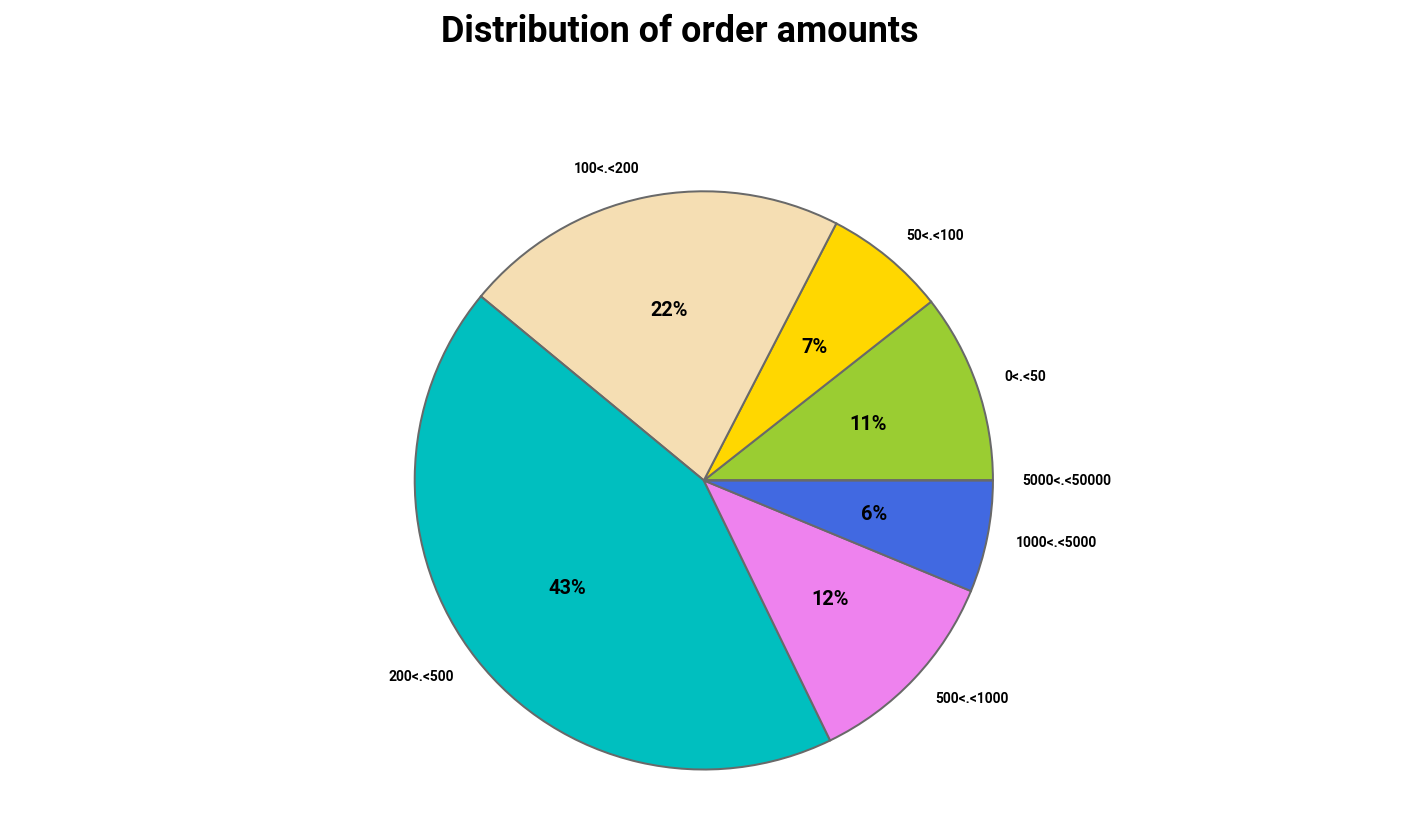

In [28]:
# Décompte des achats
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#____________________________________________
# Représentation du nombre d'achats / montant        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

## データ・エンリッチメント

3. Insight on product categories

In the dataframe, products are uniquely identified through the StockCode variable. A shrort description of the products is given in the Description variable. In this section, I intend to use the content of this latter variable in order to group the products into different categories.

3.1 Products Description

As a first step, I extract from the Description variable the information that will prove useful. To do this, I use the following function:

This function takes as input the dataframe and analyzes the content of the Description column by performing the following operations:

- extract the names (proper, common) appearing in the products description
- for each name, I extract the root of the word and aggregate the set of names associated with this particular root
- count the number of times each root appears in the dataframe
- when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

The first step of the analysis is to retrieve the list of products:

In [40]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the Description column by performing the following operations:

extract the names (proper, common) appearing in the products description
for each name, I extract the root of the word and aggregate the set of names associated with this particular root
count the number of times each root appears in the dataframe
when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)
The first step of the analysis is to retrieve the list of products:

In [41]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

In [45]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/cdsw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/cdsw/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [46]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1484


The execution of this function returns three variables:

- keywords: the list of extracted keywords
- keywords_roots: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- count_keywords: dictionary listing the number of times every word is used

At this point, I convert the count_keywords dictionary into a list, to sort the keywords according to their occurences:

In [47]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

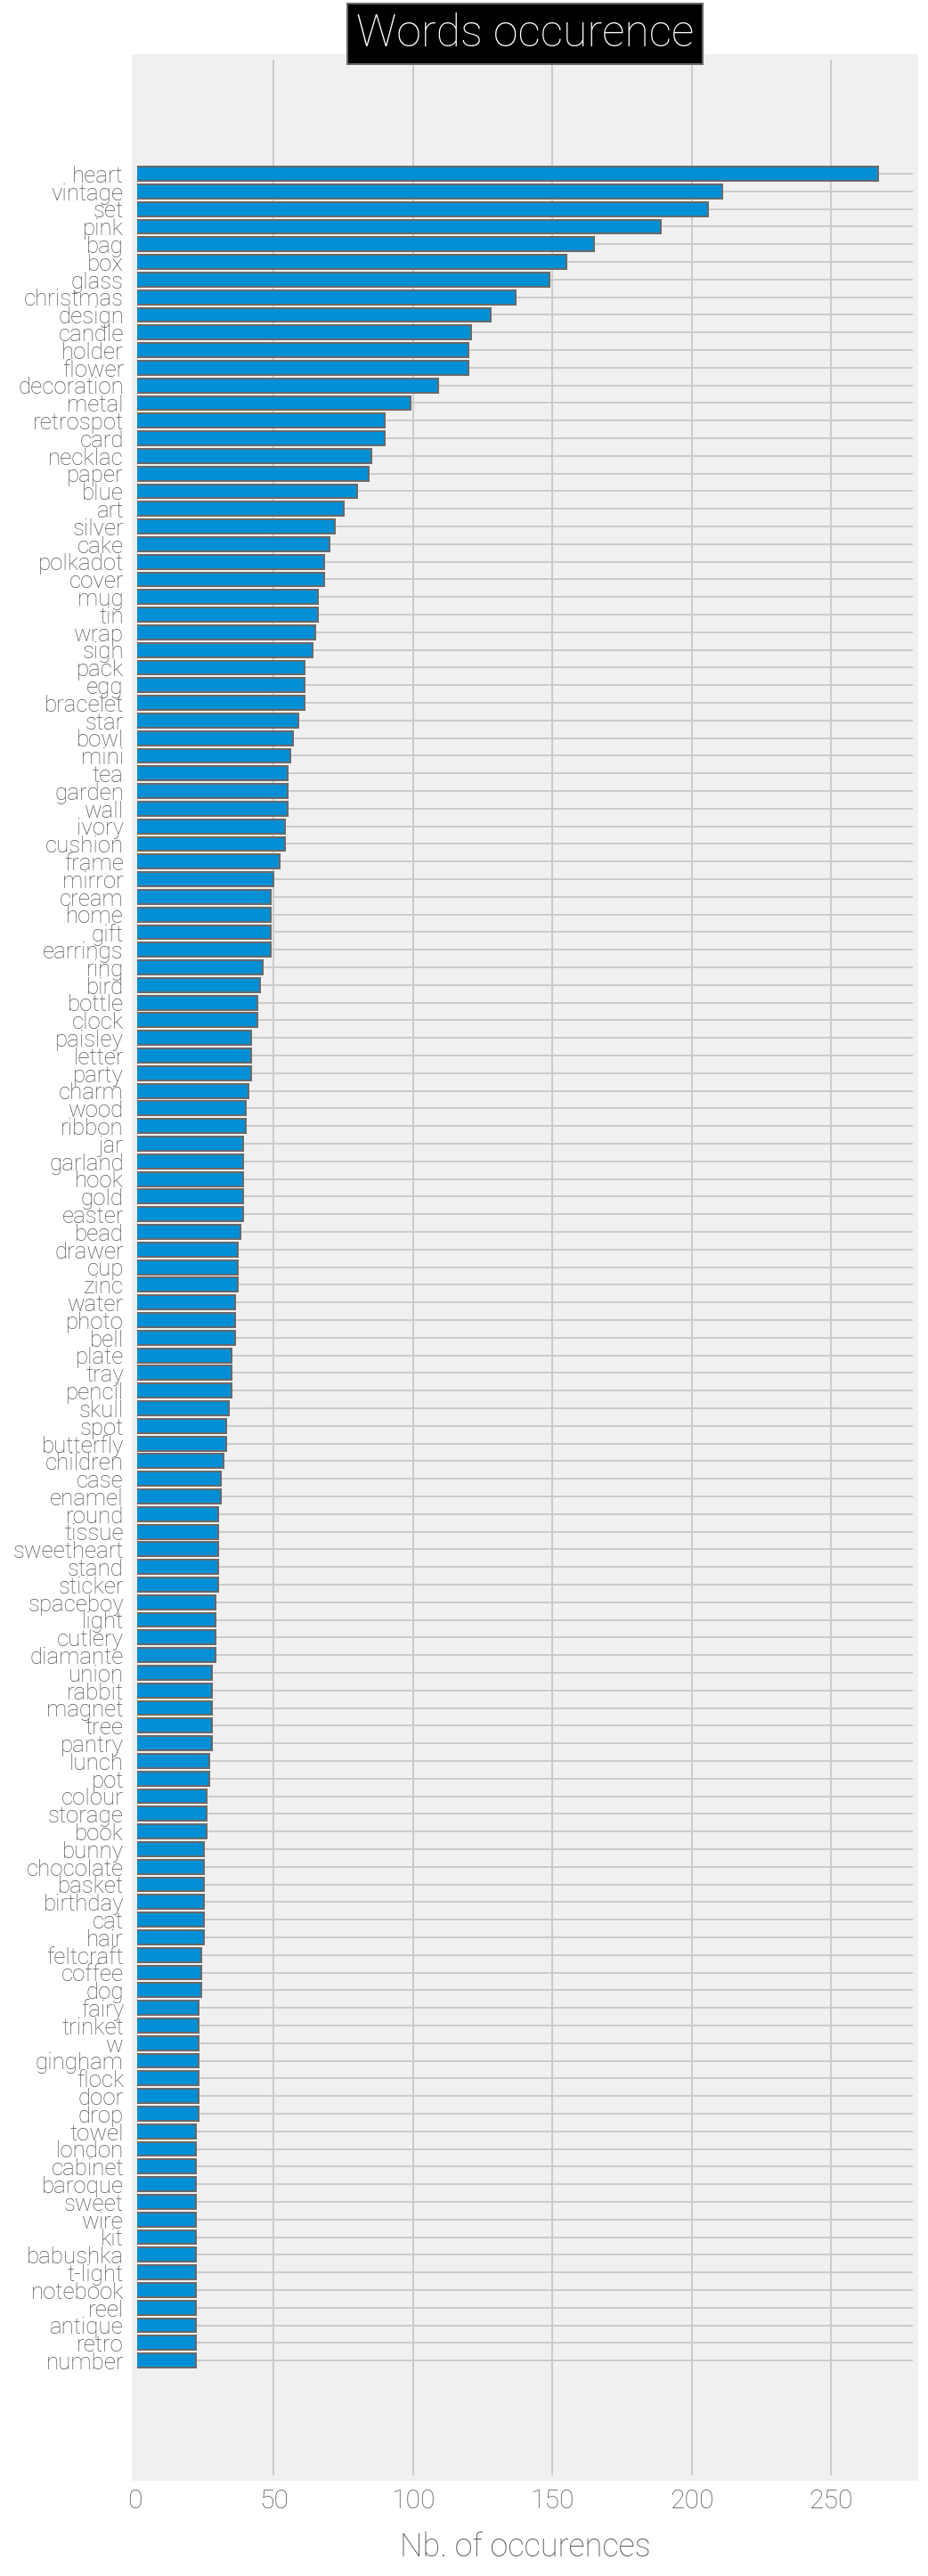

In [48]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

3.2 Defining product categories

The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, while examinating the content of the list, I note that some names are useless. Others are do not carry information, like colors. Therefore, I discard these words from the analysis that follows and also, I decide to consider only the words that appear more than 13 times.

In [49]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('mots conservés:', len(list_products))

mots conservés: 193


3.2.1 Data encoding

Now I will use these keywords to create groups of product. Firstly, I define the  X  matrix as:

In [50]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

The  X  matrix indicates the words contained in the description of the products using the one-hot-encoding principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers. Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [51]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

and to choose the appropriate ranges, I check the number of products in the different groups:

In [52]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       400                 
1<.<2       545                 
2<.<3       371                 
3<.<5       255                 
5<.<10      214                 
.>10        62                  



3.2.2 Creating clusters of products

In this section, I will group the products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the Hamming's metric. Note that the kmeans method of sklearn uses a Euclidean distance that can be used, but it is not to the best choice in the case of categorical variables. However, in order to use the Hamming's metric, we need to use the kmodes package which is not available on the current plateform. Hence, I use the kmeans method even if this is not the best choice.

In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:

In [53]:
matrix = X.as_matrix()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.1064828517407943
For n_clusters = 4 The average silhouette_score is : 0.11812384410550189
For n_clusters = 5 The average silhouette_score is : 0.14401929525367074
For n_clusters = 6 The average silhouette_score is : 0.1608843993602083
For n_clusters = 7 The average silhouette_score is : 0.1590061903759978
For n_clusters = 8 The average silhouette_score is : 0.14779550763639762
For n_clusters = 9 The average silhouette_score is : 0.15253386345787975


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of  0.1±0.05  will be obtained for all clusters with n_clusters  >  3 (we obtain slightly lower scores for the first cluster). On the other hand, I found that beyond 5 clusters, some clusters contained very few elements. I therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook, I iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:

In [54]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14401929525367074
For n_clusters = 5 The average silhouette_score is : 0.14401929525367074
For n_clusters = 5 The average silhouette_score is : 0.14401929525367074
For n_clusters = 5 The average silhouette_score is : 0.15146493005484954


4. Customer categories

4.1 Formatting data

In the previous section, the different products were grouped in five clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, I create the categorical variable categ_product where I indicate the cluster of each product :

4.1.1 Grouping products

In a second step, I decide to create the categ_N variables (with  N∈[0:4] ) that contains the amount spent in each product category:

In [55]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

In [56]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0,15.3,0.00,0.0,0.0,0.0
1,536365,WHITE METAL LANTERN,1,0.0,20.34,0.0,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,0,22.0,0.00,0.0,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1,0.0,20.34,0.0,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1,0.0,20.34,0.0,0.0,0.0


In [57]:
#________________________________________________________________
# nb de visites et stats sur le montant du panier / utilisateurs
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

KeyError: 'Column not found: categ_0'

4.2.1 Data encoding
The dataframe transactions_per_user contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [32]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].as_matrix()

NameError: name 'transactions_per_user' is not defined

## 顧客クラス分類

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in scikit-learn. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers:


In [30]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

Since the goal is to define the class to which a client belongs and this, as soon as its first visit, I only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:
    
Finally, I split the dataset in train and test sets:

In [31]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

NameError: name 'selected_customers' is not defined